# Load Cell Data Analysis

Compare load cell data values for no movement, movement 1, and movement 2 in both time domain and frequency domain using only 5 data points per plot.

We will use Power Spectral Density (PSD) and try out other frequency transforms.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from numpy.fft import fft, fftfreq

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from scipy.signal import welch


## 2. Load the Data
Replace the file names and column name with your actual CSV file names and load cell column.

In [7]:
# Example file names; update as needed
data_path = "data\\"
no_movement_file = 'No_movement.csv'
movement_1_file = 'Movement_1.csv'
movement_2_file = 'Movement_2.csv'

# Replace 'load_cell' with the actual column name
col = ' UPPER_LOAD_CELL'
col2  = ' LOWER_LOAD_CELL'


df_no = pd.read_csv(data_path + no_movement_file)
df_1 = pd.read_csv(data_path + movement_1_file)
df_2 = pd.read_csv(data_path + movement_2_file)


## 3. Extract 5-Point Segments
You can change the start index to analyze different 5-point windows.

In [8]:
start_idx = 0  # Change this to slide the window
segment_no = df_no[col].iloc[start_idx:start_idx+5].values
segment_1 = df_1[col].iloc[start_idx:start_idx+5].values
segment_2 = df_2[col].iloc[start_idx:start_idx+5].values


## 4. Plot Time Domain
Compare the 5-point segments in the time domain.

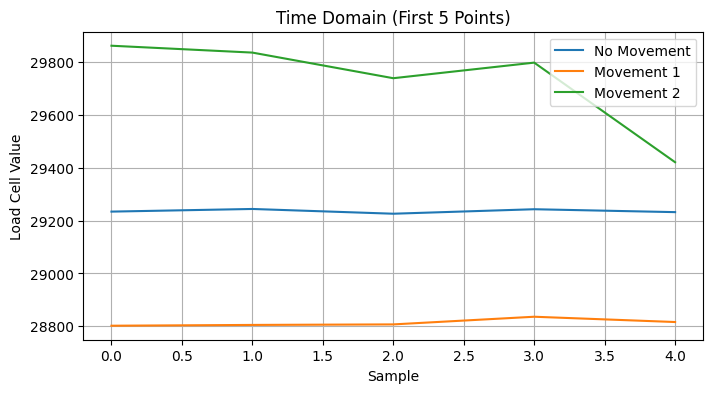

In [9]:
plt.figure(figsize=(8,4))
plt.plot(segment_no, label='No Movement')
plt.plot(segment_1, label='Movement 1')
plt.plot(segment_2, label='Movement 2')
plt.xlabel('Sample')
plt.ylabel('Load Cell Value')
plt.title('Time Domain (First 5 Points)')
plt.legend()
plt.grid(True)
plt.show()


## 5. Frequency Domain Analysis (PSD and FFT)
We use Welch's method for PSD and FFT for frequency spectrum.

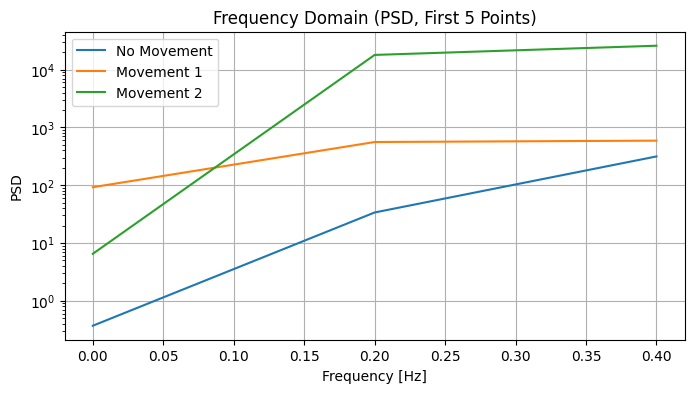

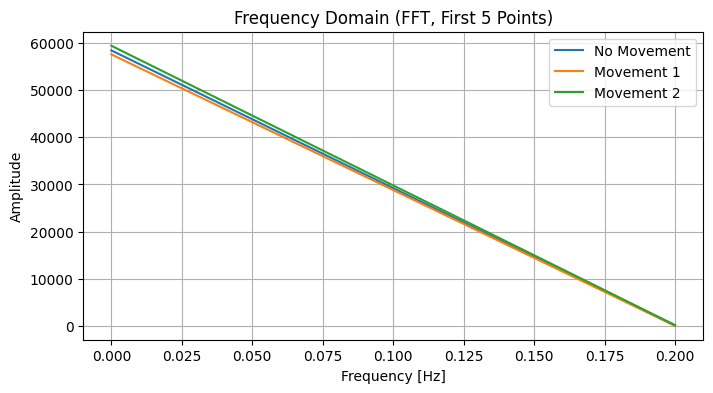

In [10]:
# Power Spectral Density (PSD)
f_no, Pxx_no = welch(segment_no, nperseg=5)
f_1, Pxx_1 = welch(segment_1, nperseg=5)
f_2, Pxx_2 = welch(segment_2, nperseg=5)

plt.figure(figsize=(8,4))
plt.semilogy(f_no, Pxx_no, label='No Movement')
plt.semilogy(f_1, Pxx_1, label='Movement 1')
plt.semilogy(f_2, Pxx_2, label='Movement 2')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Frequency Domain (PSD, First 5 Points)')
plt.legend()
plt.grid(True)
plt.show()

# FFT
N = 5
T = 1.0  # Assume sample spacing = 1
xf = fftfreq(N, T)[:N//2]
yf_no = fft(segment_no)
yf_1 = fft(segment_1)
yf_2 = fft(segment_2)

plt.figure(figsize=(8,4))
plt.plot(xf, 2.0/N * np.abs(yf_no[0:N//2]), label='No Movement')
plt.plot(xf, 2.0/N * np.abs(yf_1[0:N//2]), label='Movement 1')
plt.plot(xf, 2.0/N * np.abs(yf_2[0:N//2]), label='Movement 2')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Frequency Domain (FFT, First 5 Points)')
plt.legend()
plt.grid(True)
plt.show()


## 6. (Optional) Slide the 5-Point Window
You can loop through your data in steps of 5 or with overlap to analyze all possible windows.

In [9]:
window_size = 5

def interpret_window(segment_upper, segment_lower, Pxx_upper, Pxx_lower, label, window_idx):
    interp = f"""
**Window {window_idx}: {label}**

- **Time Domain (Upper):** Range: {segment_upper.min():.2f} to {segment_upper.max():.2f}
- **Time Domain (Lower):** Range: {segment_lower.min():.2f} to {segment_lower.max():.2f}
- **PSD (Upper):** Max Power: {Pxx_upper.max():.2f}
- **PSD (Lower):** Max Power: {Pxx_lower.max():.2f}

- If the upper/lower load cell shows higher variance or PSD, it may indicate more dynamic movement in that window.
- Compare the difference between upper and lower to see if the load is distributed differently during movement.
"""
    display(Markdown(interp))

In [10]:
from IPython.display import display, Markdown

def interpret_row_range_multi(segs, psds, row_range):
    interp = f"**Interpretation for Rows {row_range}:**\n\n"
    for label in segs:
        interp += (
            f"- **{label}:**\n"
            f"  - Upper Load Cell: Range {segs[label]['upper'].min():.2f} to {segs[label]['upper'].max():.2f}, "
            f"Max PSD {psds[label]['upper'][1].max():.2f}\n"
            f"  - Lower Load Cell: Range {segs[label]['lower'].min():.2f} to {segs[label]['lower'].max():.2f}, "
            f"Max PSD {psds[label]['lower'][1].max():.2f}\n"
        )
    interp += (
        "\n- Compare the range and PSD values across movement types. "
        "Larger ranges or higher PSDs suggest more dynamic or energetic activity in those rows. "
        "If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern."
    )
    display(Markdown(interp))

def sliding_window_plot_all_step_rows(df_no, df_1, df_2, col, col2, window_size=5):
    n_windows = min(
        len(df_no) // window_size,
        len(df_1) // window_size,
        len(df_2) // window_size
    )
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        row_range = f"{start}-{end-1}"
        # Extract window segments for each movement and load cell
        segs = {}
        for label, df in zip(
            ['No Movement', 'Movement 1', 'Movement 2'],
            [df_no, df_1, df_2]
        ):
            segs[label] = {
                'upper': df[col].iloc[start:end].values,
                'lower': df[col2].iloc[start:end].values
            }
        
        # Compute PSDs
        psds = {}
        for label in segs:
            psds[label] = {
                'upper': welch(segs[label]['upper'], nperseg=window_size),
                'lower': welch(segs[label]['lower'], nperseg=window_size)
            }
        
        # Plotting
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f"Rows {start} to {end-1}")

        # Time Domain - Upper
        for label in segs:
            axs[0,0].plot(range(start, end), segs[label]['upper'], label=label)
        axs[0,0].set_title('Upper Load Cell - Time')
        axs[0,0].set_xlabel('Row Number')
        axs[0,0].set_ylabel('Value')
        axs[0,0].legend()
        axs[0,0].grid(True)

        # Time Domain - Lower
        for label in segs:
            axs[1,0].plot(range(start, end), segs[label]['lower'], label=label)
        axs[1,0].set_title('Lower Load Cell - Time')
        axs[1,0].set_xlabel('Row Number')
        axs[1,0].set_ylabel('Value')
        axs[1,0].legend()
        axs[1,0].grid(True)

        # PSD - Upper
        for label in psds:
            f, Pxx = psds[label]['upper']
            axs[0,1].semilogy(f, Pxx, label=label)
        axs[0,1].set_title('Upper Load Cell - PSD')
        axs[0,1].set_xlabel('Frequency [Hz]')
        axs[0,1].set_ylabel('PSD')
        axs[0,1].legend()
        axs[0,1].grid(True)

        # PSD - Lower
        for label in psds:
            f, Pxx = psds[label]['lower']
            axs[1,1].semilogy(f, Pxx, label=label)
        axs[1,1].set_title('Lower Load Cell - PSD')
        axs[1,1].set_xlabel('Frequency [Hz]')
        axs[1,1].set_ylabel('PSD')
        axs[1,1].legend()
        axs[1,1].grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # Show interpretation after the plots
        interpret_row_range_multi(segs, psds, row_range)

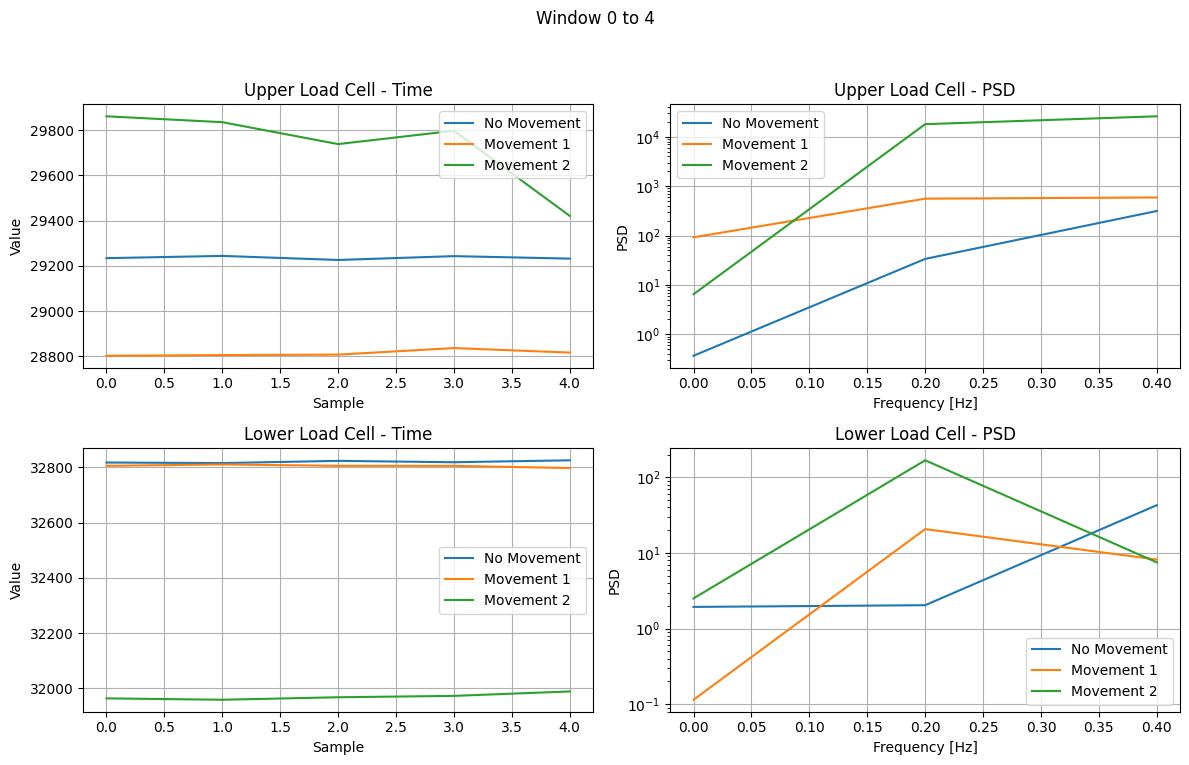

**Interpretation for Window 0-4:**

- **No Movement:**
  - Upper Load Cell: Range 29226.00 to 29244.00, Max PSD 314.56
  - Lower Load Cell: Range 32815.00 to 32825.00, Max PSD 42.85
- **Movement 1:**
  - Upper Load Cell: Range 28802.00 to 28836.00, Max PSD 590.61
  - Lower Load Cell: Range 32797.00 to 32810.00, Max PSD 20.68
- **Movement 2:**
  - Upper Load Cell: Range 29421.00 to 29862.00, Max PSD 25982.01
  - Lower Load Cell: Range 31959.00 to 31989.00, Max PSD 167.90

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

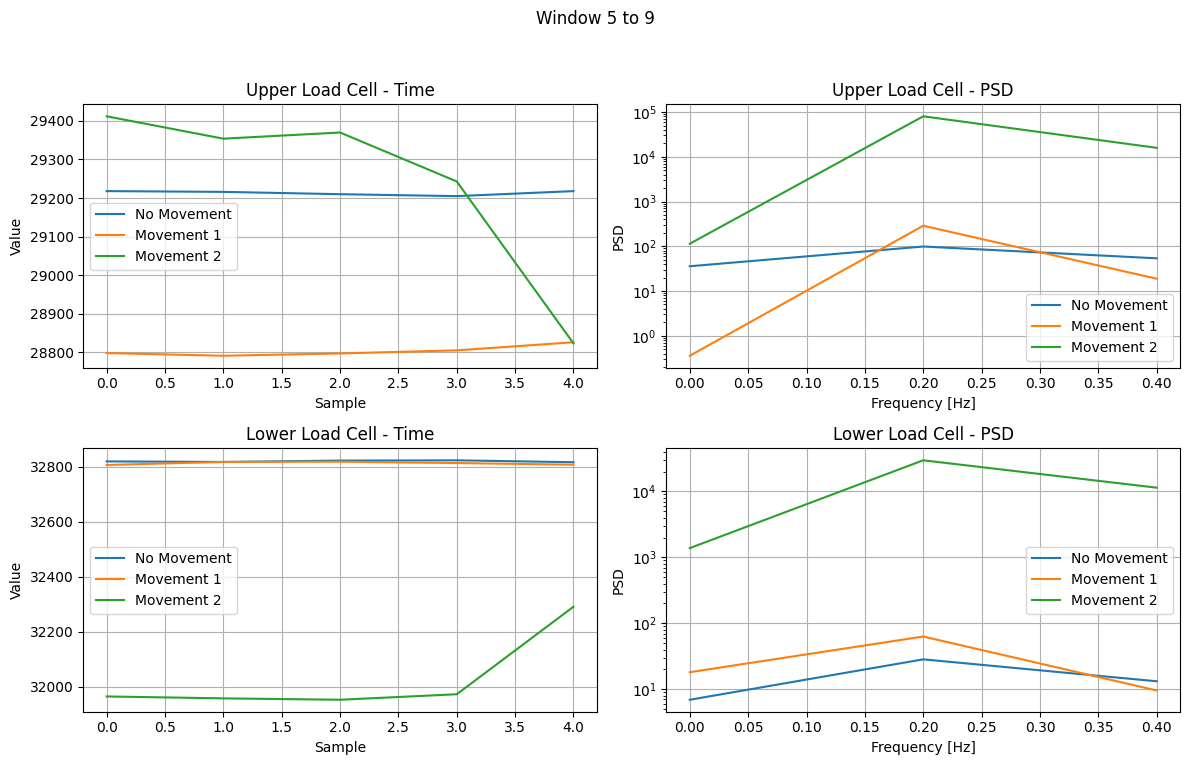

**Interpretation for Window 5-9:**

- **No Movement:**
  - Upper Load Cell: Range 29205.00 to 29218.00, Max PSD 98.59
  - Lower Load Cell: Range 32816.00 to 32823.00, Max PSD 28.40
- **Movement 1:**
  - Upper Load Cell: Range 28791.00 to 28826.00, Max PSD 287.31
  - Lower Load Cell: Range 32806.00 to 32818.00, Max PSD 63.01
- **Movement 2:**
  - Upper Load Cell: Range 28823.00 to 29412.00, Max PSD 80265.13
  - Lower Load Cell: Range 31953.00 to 32291.00, Max PSD 29660.45

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

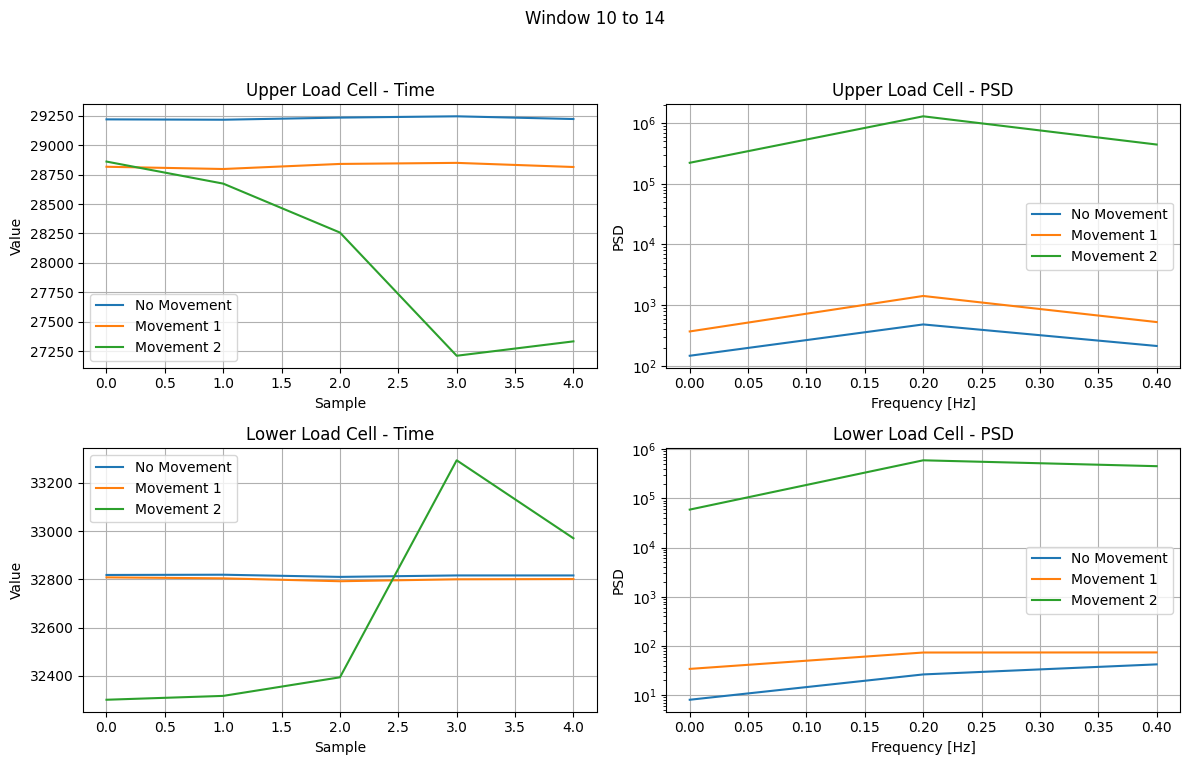

**Interpretation for Window 10-14:**

- **No Movement:**
  - Upper Load Cell: Range 29215.00 to 29244.00, Max PSD 481.39
  - Lower Load Cell: Range 32810.00 to 32819.00, Max PSD 42.27
- **Movement 1:**
  - Upper Load Cell: Range 28797.00 to 28849.00, Max PSD 1417.85
  - Lower Load Cell: Range 32792.00 to 32808.00, Max PSD 73.94
- **Movement 2:**
  - Upper Load Cell: Range 27213.00 to 28860.00, Max PSD 1294850.39
  - Lower Load Cell: Range 32301.00 to 33293.00, Max PSD 594193.44

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

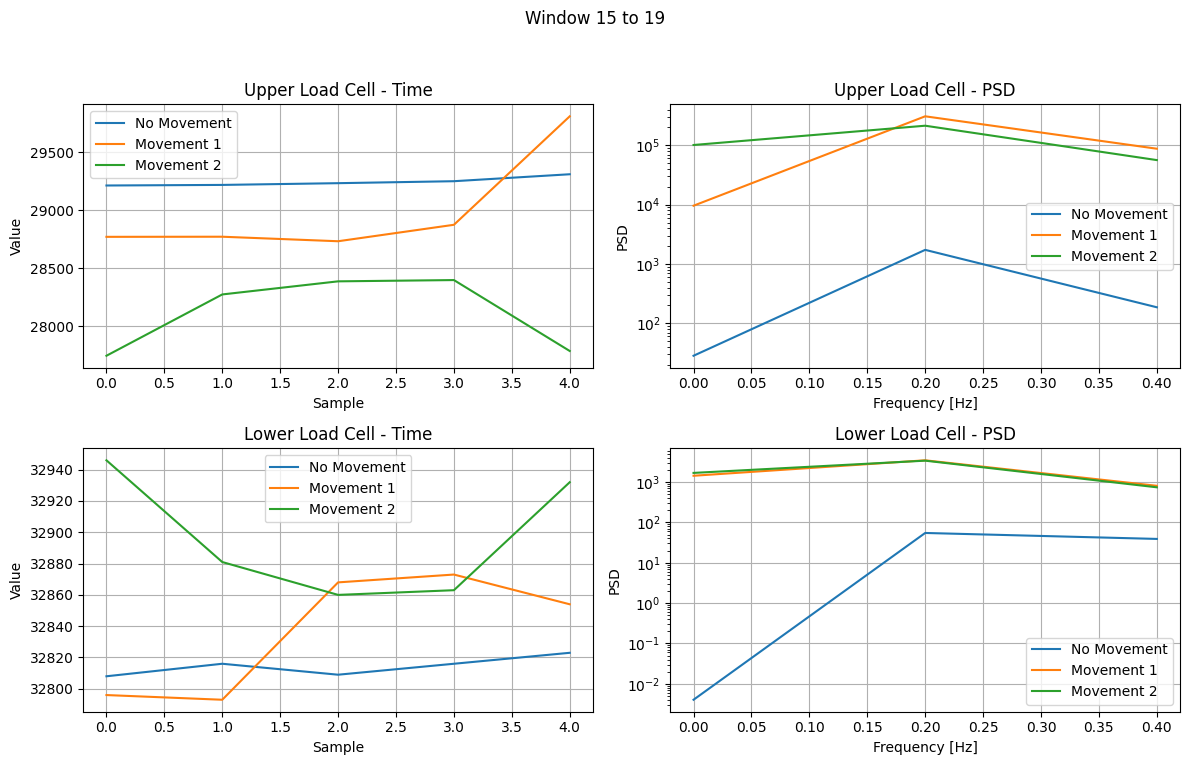

**Interpretation for Window 15-19:**

- **No Movement:**
  - Upper Load Cell: Range 29215.00 to 29312.00, Max PSD 1729.80
  - Lower Load Cell: Range 32808.00 to 32823.00, Max PSD 54.65
- **Movement 1:**
  - Upper Load Cell: Range 28734.00 to 29812.00, Max PSD 308397.57
  - Lower Load Cell: Range 32793.00 to 32873.00, Max PSD 3451.85
- **Movement 2:**
  - Upper Load Cell: Range 27746.00 to 28399.00, Max PSD 214094.90
  - Lower Load Cell: Range 32860.00 to 32946.00, Max PSD 3382.02

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

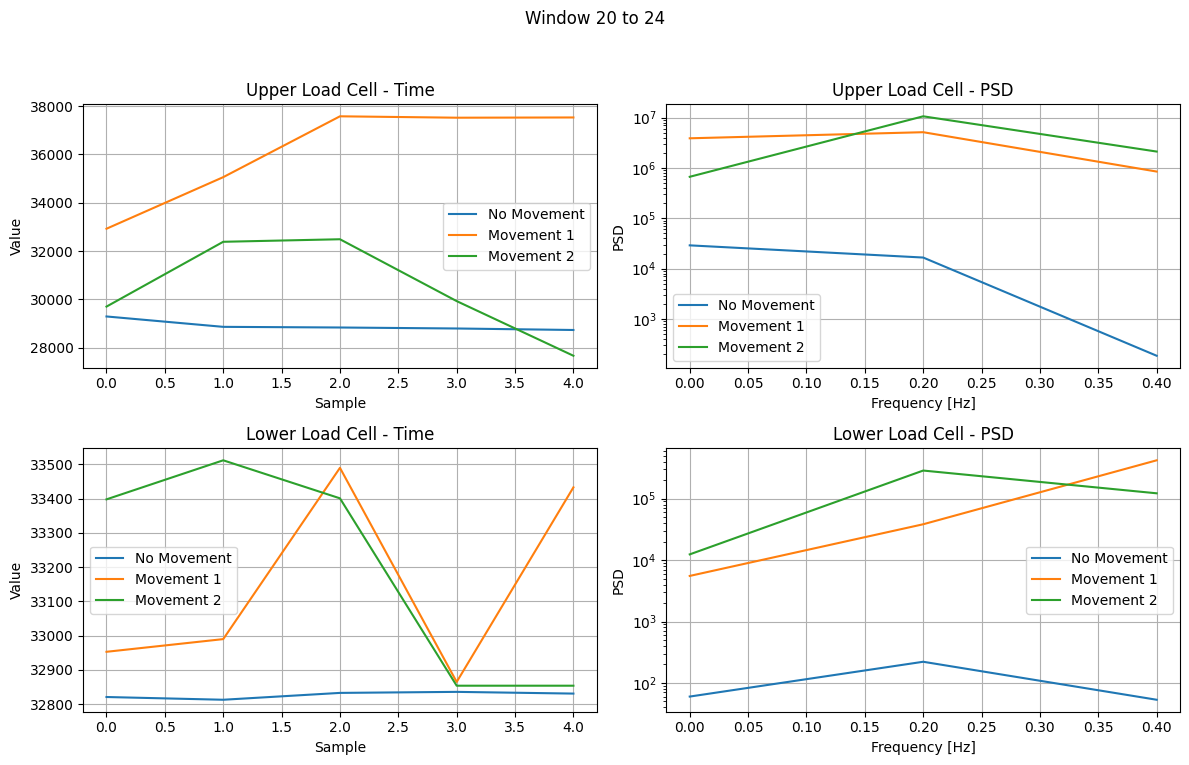

**Interpretation for Window 20-24:**

- **No Movement:**
  - Upper Load Cell: Range 28731.00 to 29291.00, Max PSD 29039.24
  - Lower Load Cell: Range 32813.00 to 32836.00, Max PSD 221.37
- **Movement 1:**
  - Upper Load Cell: Range 32925.00 to 37581.00, Max PSD 5143722.88
  - Lower Load Cell: Range 32865.00 to 33490.00, Max PSD 420541.05
- **Movement 2:**
  - Upper Load Cell: Range 27664.00 to 32489.00, Max PSD 10643696.26
  - Lower Load Cell: Range 32854.00 to 33512.00, Max PSD 286474.49

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

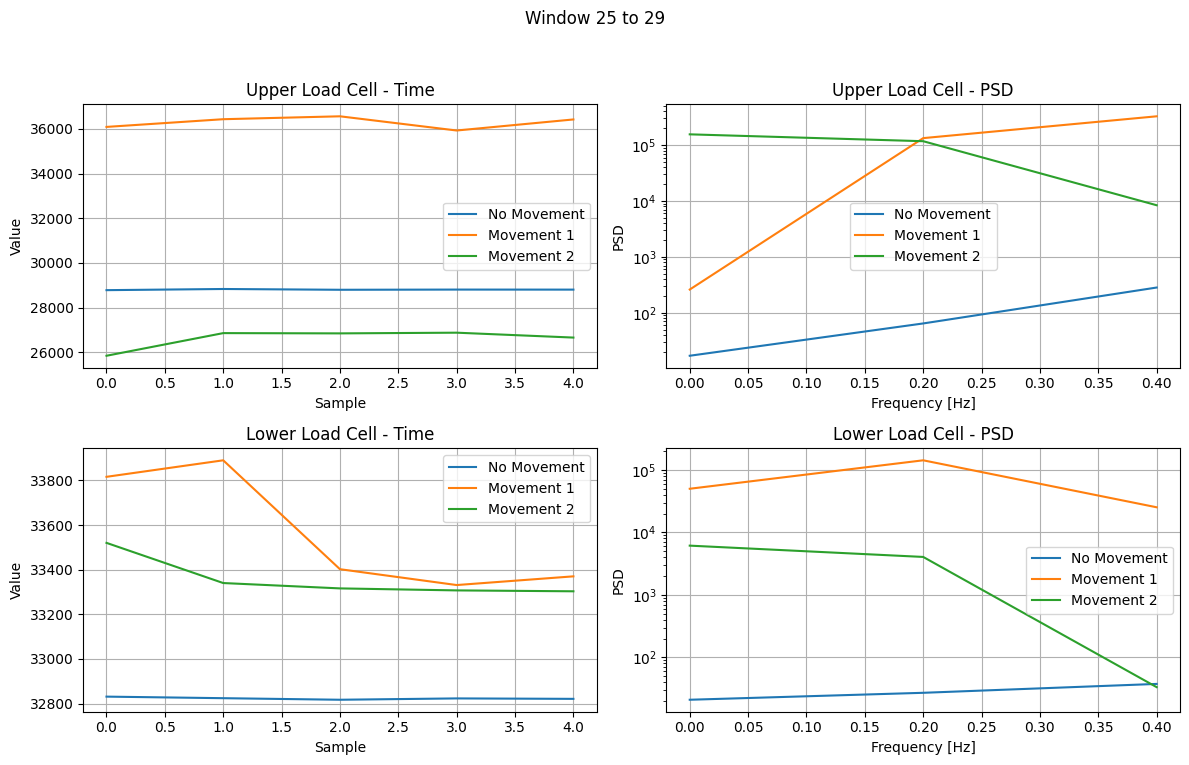

**Interpretation for Window 25-29:**

- **No Movement:**
  - Upper Load Cell: Range 28778.00 to 28830.00, Max PSD 283.09
  - Lower Load Cell: Range 32817.00 to 32831.00, Max PSD 37.60
- **Movement 1:**
  - Upper Load Cell: Range 35929.00 to 36565.00, Max PSD 327786.91
  - Lower Load Cell: Range 33331.00 to 33890.00, Max PSD 142668.55
- **Movement 2:**
  - Upper Load Cell: Range 25840.00 to 26873.00, Max PSD 155942.64
  - Lower Load Cell: Range 33303.00 to 33520.00, Max PSD 6145.02

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

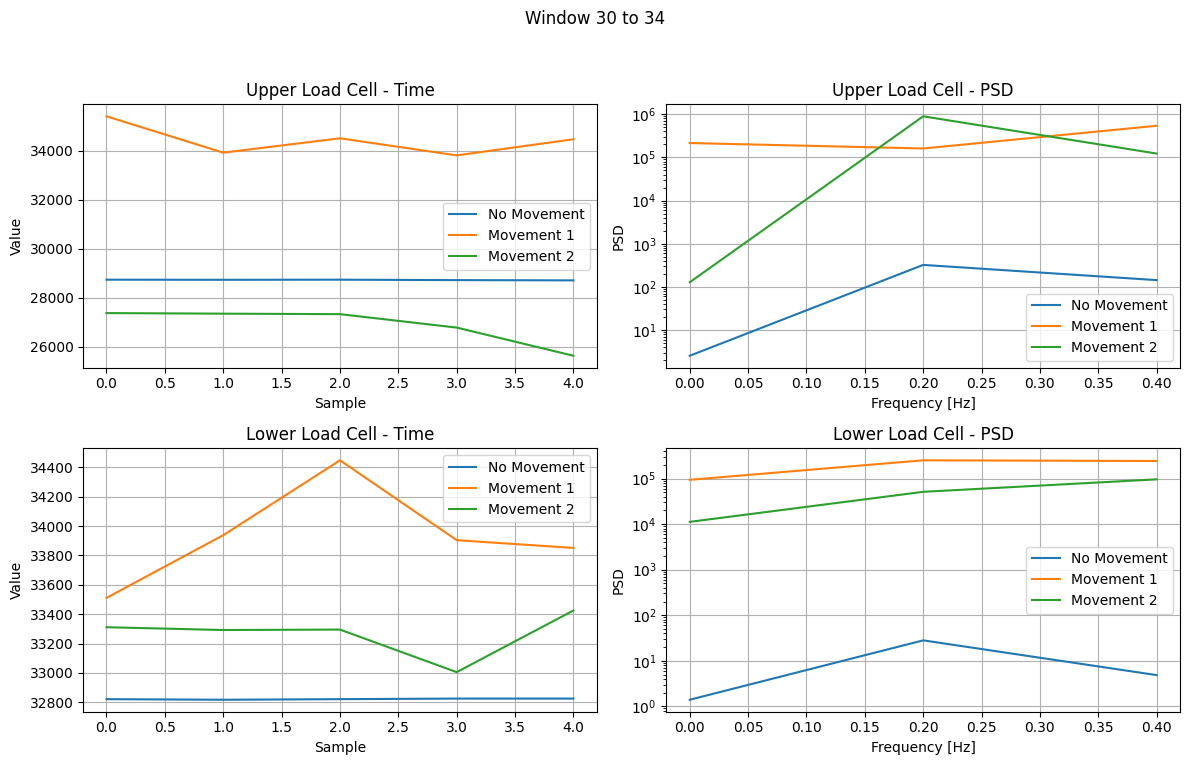

**Interpretation for Window 30-34:**

- **No Movement:**
  - Upper Load Cell: Range 28712.00 to 28740.00, Max PSD 323.16
  - Lower Load Cell: Range 32817.00 to 32825.00, Max PSD 28.08
- **Movement 1:**
  - Upper Load Cell: Range 33820.00 to 35417.00, Max PSD 540468.46
  - Lower Load Cell: Range 33511.00 to 34448.00, Max PSD 251487.71
- **Movement 2:**
  - Upper Load Cell: Range 25631.00 to 27375.00, Max PSD 895373.42
  - Lower Load Cell: Range 33005.00 to 33425.00, Max PSD 96026.94

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

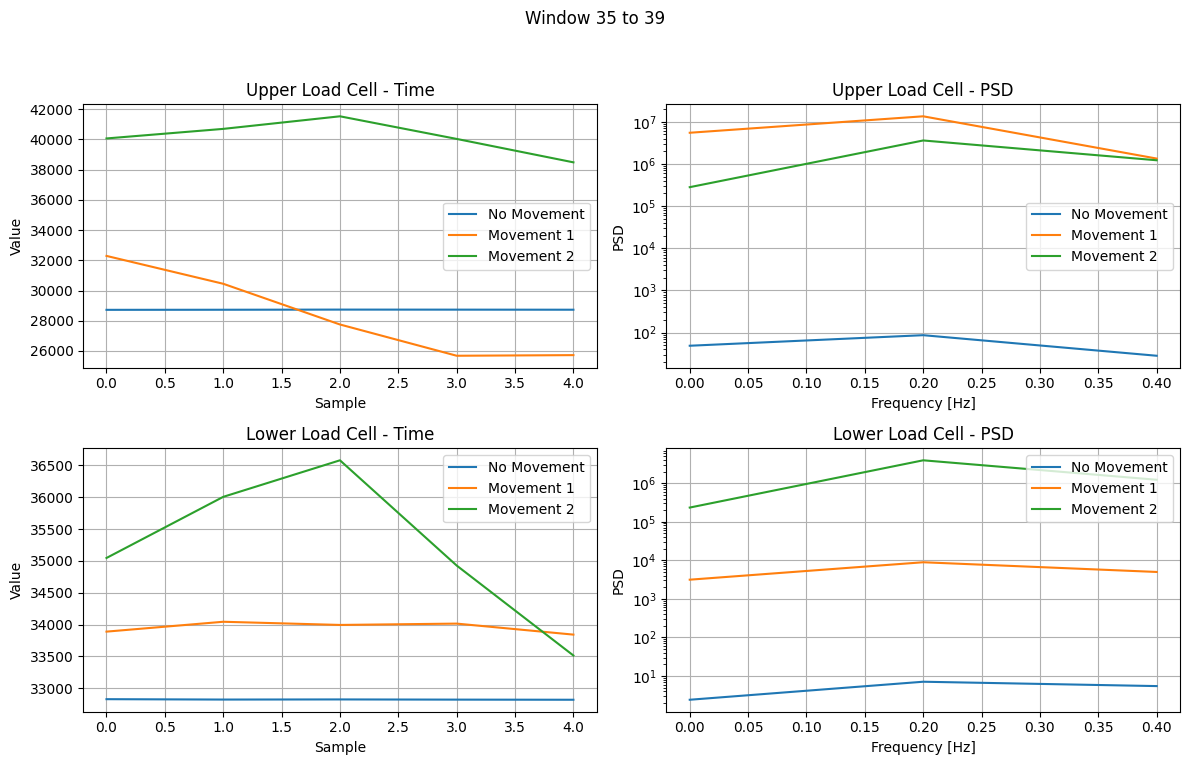

**Interpretation for Window 35-39:**

- **No Movement:**
  - Upper Load Cell: Range 28720.00 to 28736.00, Max PSD 86.89
  - Lower Load Cell: Range 32819.00 to 32828.00, Max PSD 7.11
- **Movement 1:**
  - Upper Load Cell: Range 25680.00 to 32291.00, Max PSD 13501768.52
  - Lower Load Cell: Range 33842.00 to 34044.00, Max PSD 8897.67
- **Movement 2:**
  - Upper Load Cell: Range 38487.00 to 41535.00, Max PSD 3608507.88
  - Lower Load Cell: Range 33514.00 to 36580.00, Max PSD 3911047.72

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

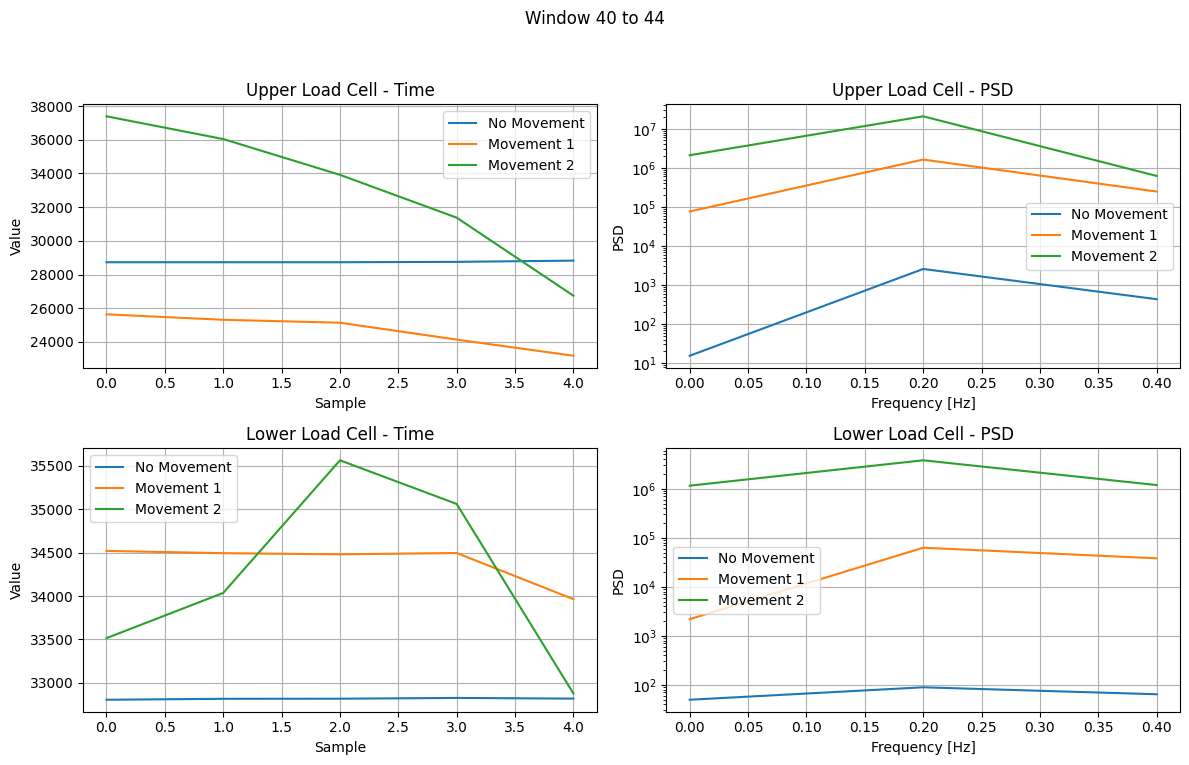

**Interpretation for Window 40-44:**

- **No Movement:**
  - Upper Load Cell: Range 28733.00 to 28828.00, Max PSD 2568.23
  - Lower Load Cell: Range 32805.00 to 32826.00, Max PSD 88.99
- **Movement 1:**
  - Upper Load Cell: Range 23184.00 to 25642.00, Max PSD 1623635.27
  - Lower Load Cell: Range 33964.00 to 34520.00, Max PSD 62609.69
- **Movement 2:**
  - Upper Load Cell: Range 26747.00 to 37392.00, Max PSD 20792357.83
  - Lower Load Cell: Range 32877.00 to 35564.00, Max PSD 3803906.76

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

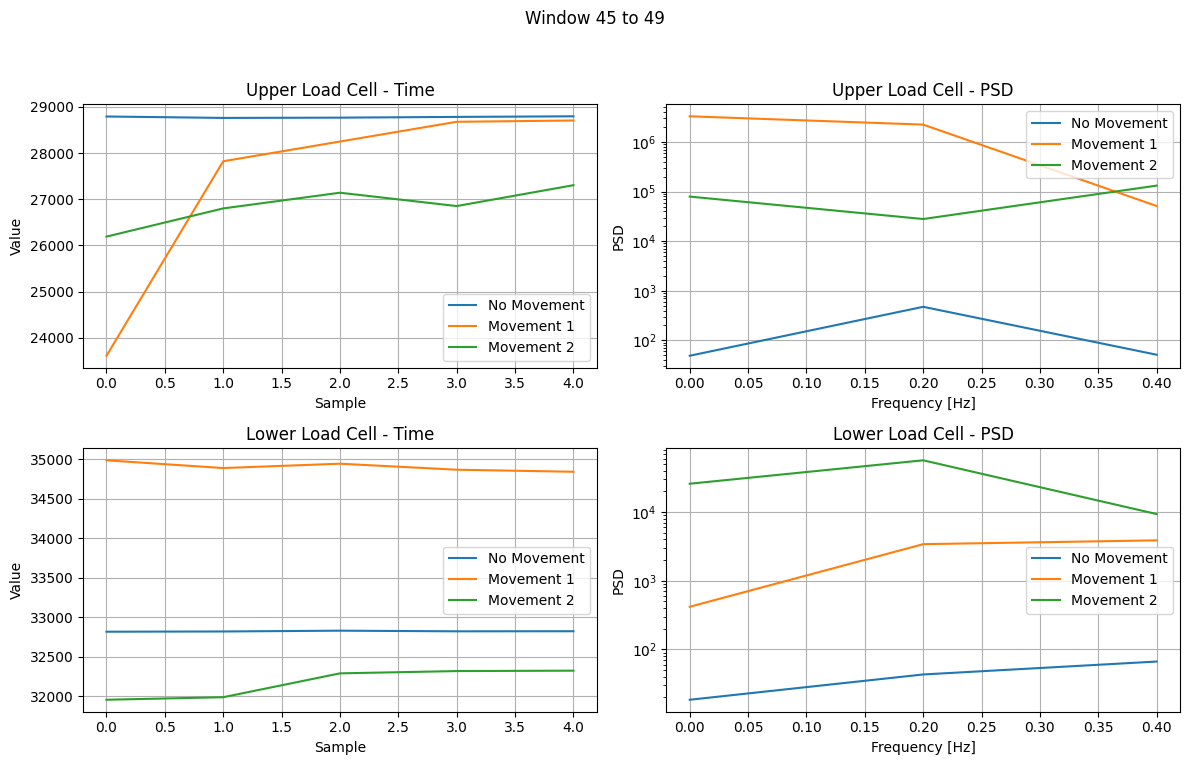

**Interpretation for Window 45-49:**

- **No Movement:**
  - Upper Load Cell: Range 28763.00 to 28798.00, Max PSD 475.52
  - Lower Load Cell: Range 32818.00 to 32831.00, Max PSD 66.61
- **Movement 1:**
  - Upper Load Cell: Range 23609.00 to 28707.00, Max PSD 3305787.52
  - Lower Load Cell: Range 34842.00 to 34987.00, Max PSD 3871.97
- **Movement 2:**
  - Upper Load Cell: Range 26191.00 to 27305.00, Max PSD 132276.80
  - Lower Load Cell: Range 31957.00 to 32325.00, Max PSD 56653.14

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

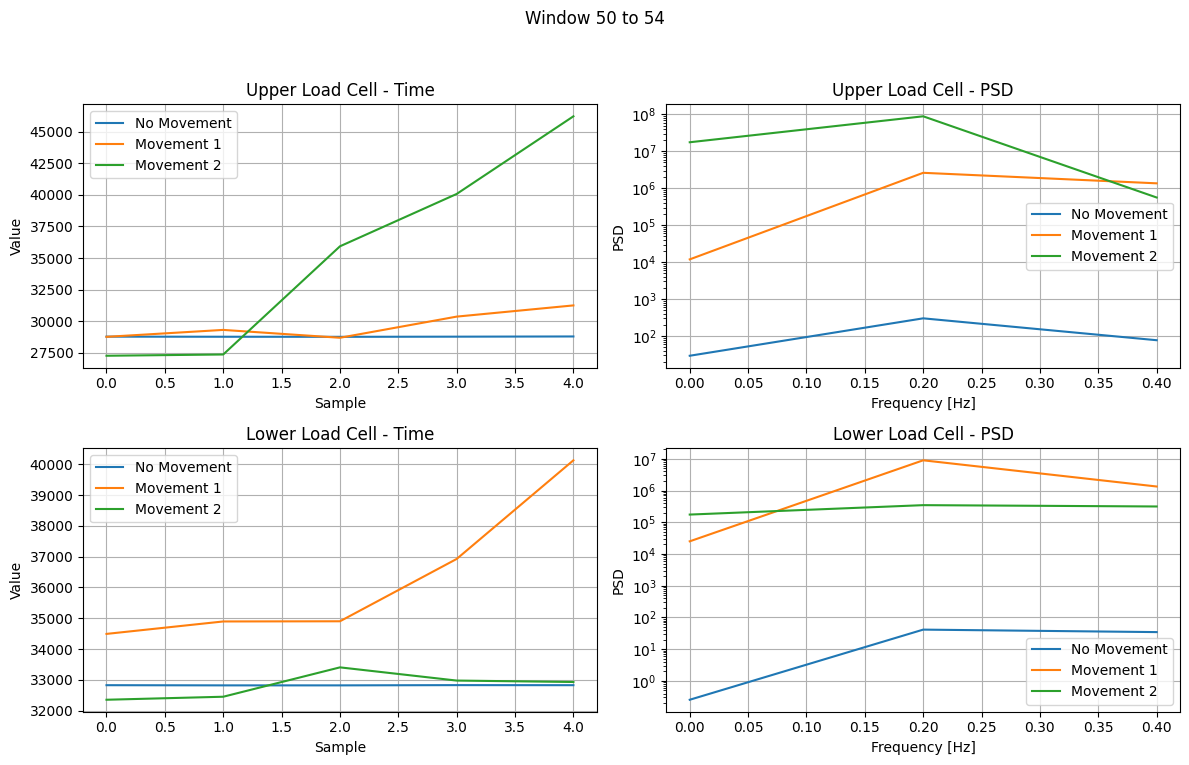

**Interpretation for Window 50-54:**

- **No Movement:**
  - Upper Load Cell: Range 28752.00 to 28780.00, Max PSD 301.01
  - Lower Load Cell: Range 32819.00 to 32827.00, Max PSD 41.38
- **Movement 1:**
  - Upper Load Cell: Range 28677.00 to 31242.00, Max PSD 2624913.16
  - Lower Load Cell: Range 34491.00 to 40130.00, Max PSD 9000966.65
- **Movement 2:**
  - Upper Load Cell: Range 27251.00 to 46235.00, Max PSD 88933140.26
  - Lower Load Cell: Range 32352.00 to 33404.00, Max PSD 347209.62

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

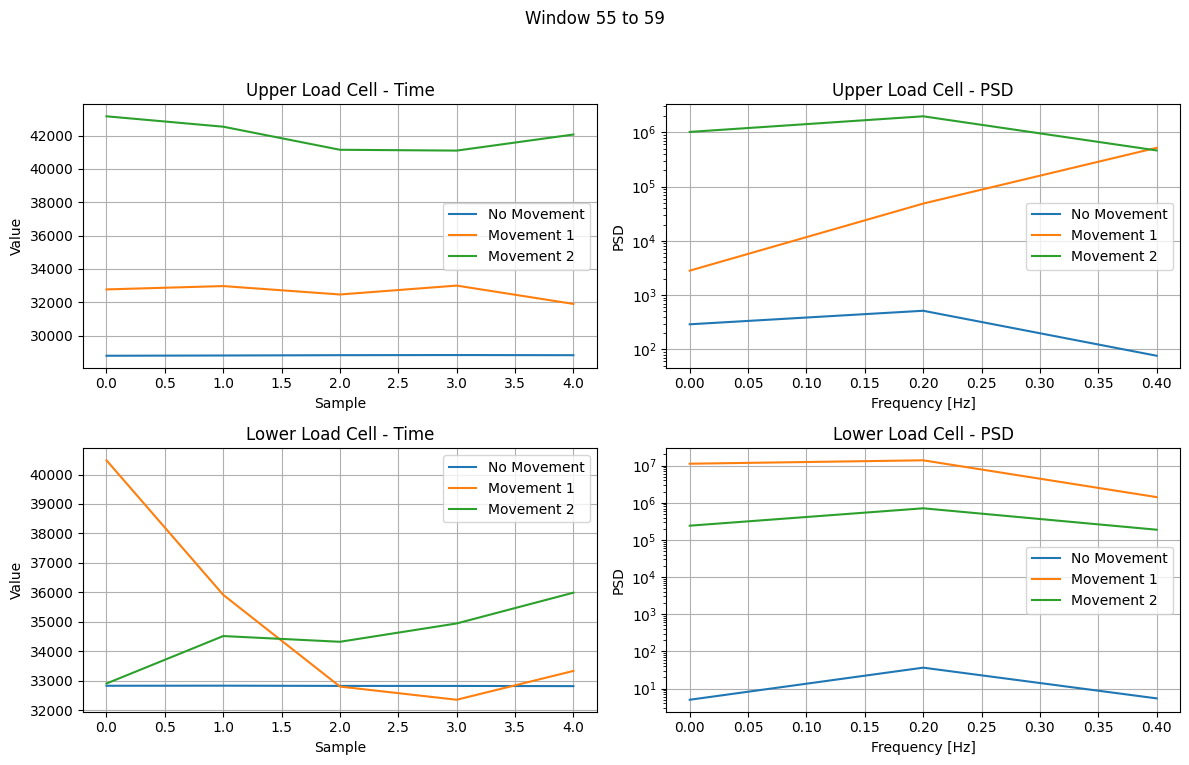

**Interpretation for Window 55-59:**

- **No Movement:**
  - Upper Load Cell: Range 28789.00 to 28831.00, Max PSD 515.43
  - Lower Load Cell: Range 32812.00 to 32827.00, Max PSD 36.46
- **Movement 1:**
  - Upper Load Cell: Range 31901.00 to 33000.00, Max PSD 517792.75
  - Lower Load Cell: Range 32349.00 to 40483.00, Max PSD 13872740.62
- **Movement 2:**
  - Upper Load Cell: Range 41103.00 to 43161.00, Max PSD 1969321.38
  - Lower Load Cell: Range 32901.00 to 35986.00, Max PSD 709007.38

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

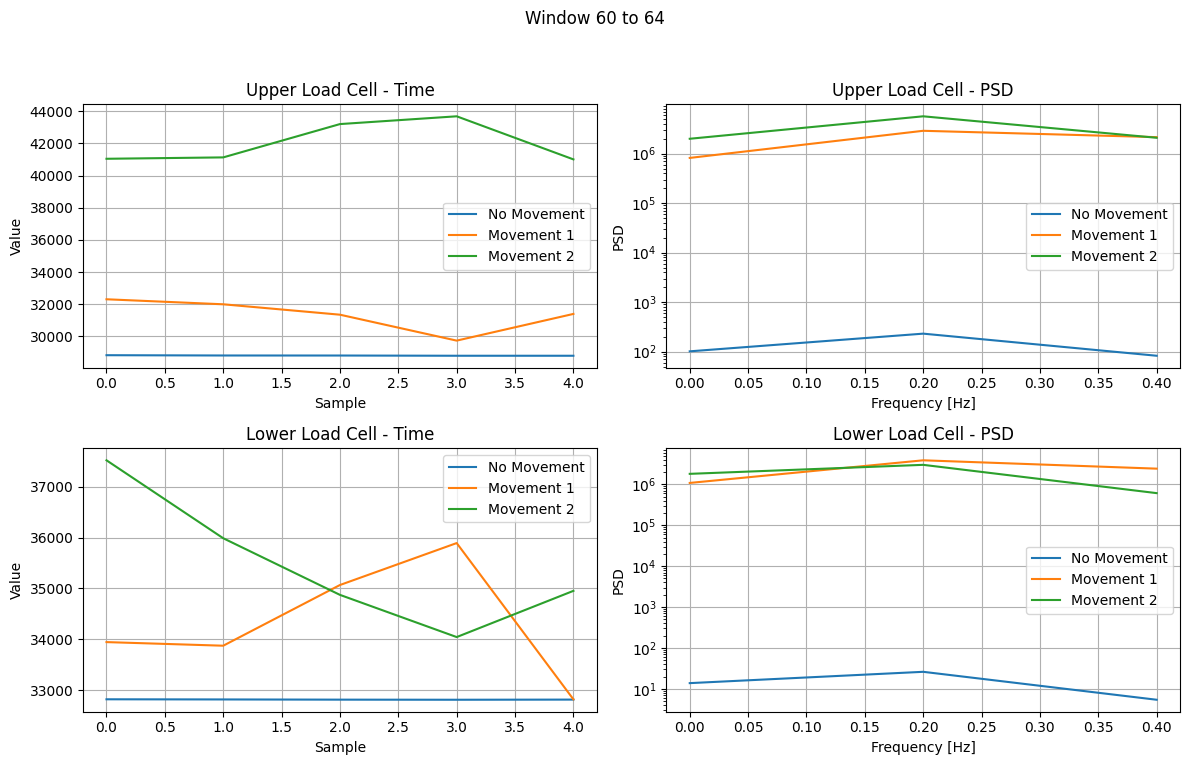

**Interpretation for Window 60-64:**

- **No Movement:**
  - Upper Load Cell: Range 28799.00 to 28833.00, Max PSD 231.47
  - Lower Load Cell: Range 32811.00 to 32820.00, Max PSD 26.05
- **Movement 1:**
  - Upper Load Cell: Range 29740.00 to 32311.00, Max PSD 2889665.26
  - Lower Load Cell: Range 32819.00 to 35893.00, Max PSD 3886235.56
- **Movement 2:**
  - Upper Load Cell: Range 41010.00 to 43689.00, Max PSD 5667236.77
  - Lower Load Cell: Range 34044.00 to 37521.00, Max PSD 3010533.94

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

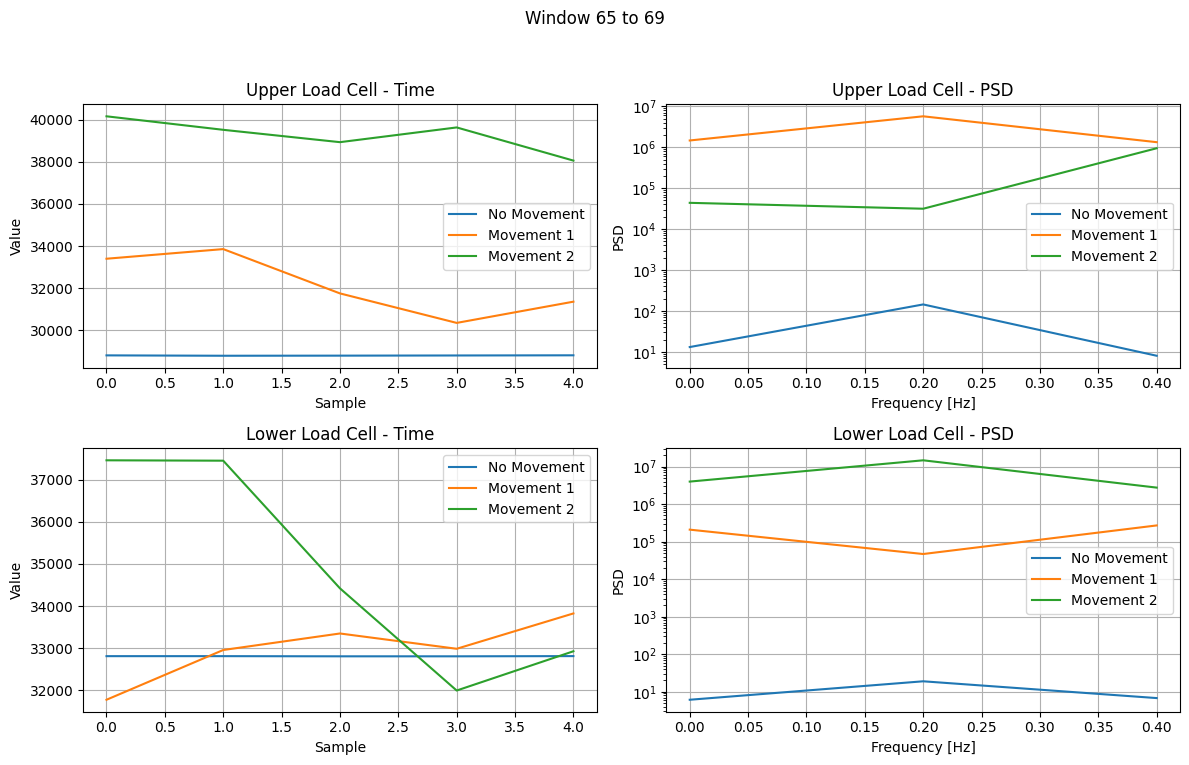

**Interpretation for Window 65-69:**

- **No Movement:**
  - Upper Load Cell: Range 28784.00 to 28805.00, Max PSD 144.45
  - Lower Load Cell: Range 32807.00 to 32812.00, Max PSD 19.03
- **Movement 1:**
  - Upper Load Cell: Range 30345.00 to 33853.00, Max PSD 5695015.37
  - Lower Load Cell: Range 31776.00 to 33825.00, Max PSD 271228.90
- **Movement 2:**
  - Upper Load Cell: Range 38059.00 to 40164.00, Max PSD 944100.49
  - Lower Load Cell: Range 31995.00 to 37460.00, Max PSD 14763612.23

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

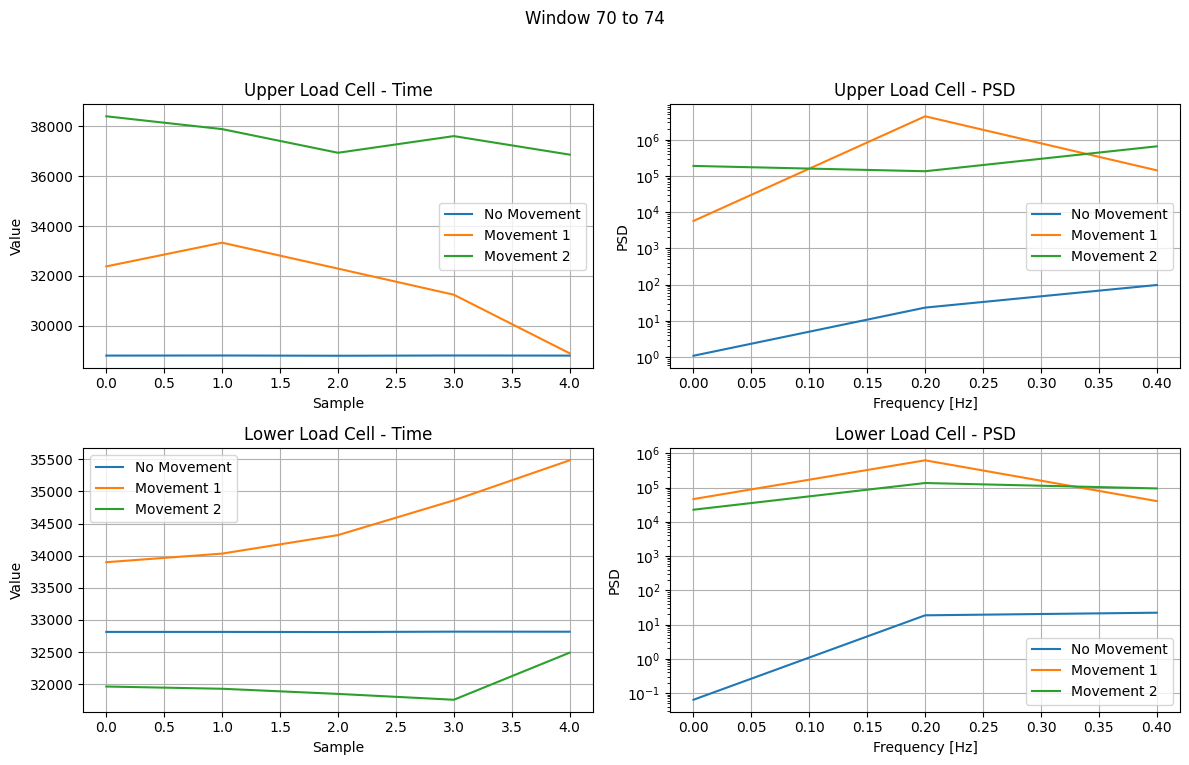

**Interpretation for Window 70-74:**

- **No Movement:**
  - Upper Load Cell: Range 28797.00 to 28807.00, Max PSD 97.55
  - Lower Load Cell: Range 32812.00 to 32818.00, Max PSD 22.19
- **Movement 1:**
  - Upper Load Cell: Range 28895.00 to 33333.00, Max PSD 4438134.80
  - Lower Load Cell: Range 33899.00 to 35485.00, Max PSD 626860.59
- **Movement 2:**
  - Upper Load Cell: Range 36865.00 to 38403.00, Max PSD 658212.73
  - Lower Load Cell: Range 31758.00 to 32491.00, Max PSD 136092.96

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

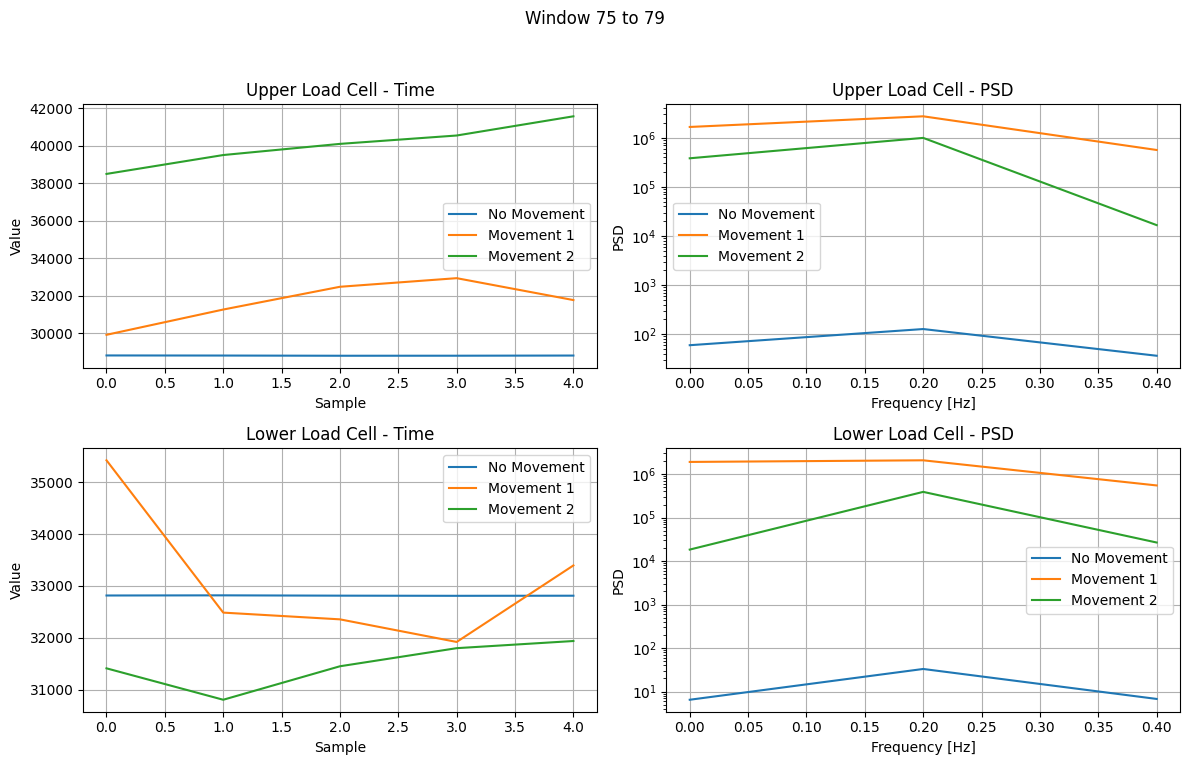

**Interpretation for Window 75-79:**

- **No Movement:**
  - Upper Load Cell: Range 28792.00 to 28808.00, Max PSD 127.59
  - Lower Load Cell: Range 32810.00 to 32819.00, Max PSD 33.07
- **Movement 1:**
  - Upper Load Cell: Range 29909.00 to 32930.00, Max PSD 2734289.16
  - Lower Load Cell: Range 31920.00 to 35424.00, Max PSD 2078974.09
- **Movement 2:**
  - Upper Load Cell: Range 38491.00 to 41564.00, Max PSD 994111.10
  - Lower Load Cell: Range 30805.00 to 31938.00, Max PSD 390757.85

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

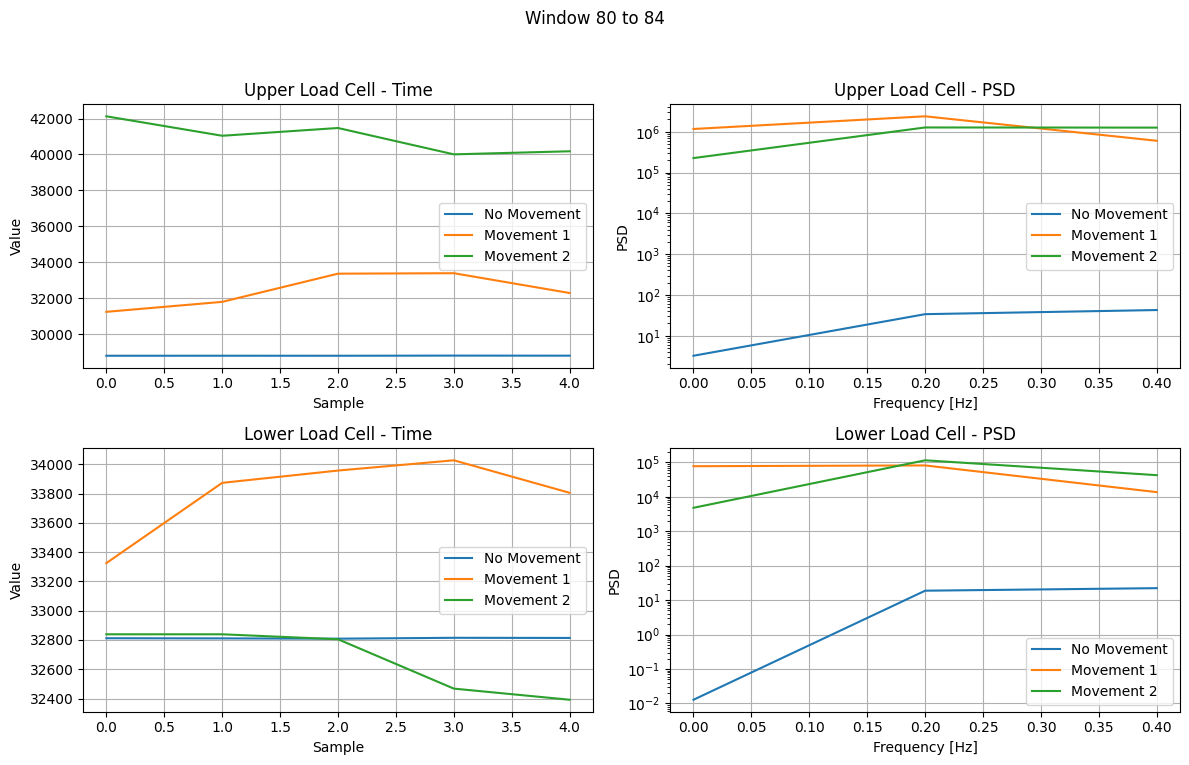

**Interpretation for Window 80-84:**

- **No Movement:**
  - Upper Load Cell: Range 28795.00 to 28803.00, Max PSD 42.72
  - Lower Load Cell: Range 32809.00 to 32815.00, Max PSD 22.19
- **Movement 1:**
  - Upper Load Cell: Range 31240.00 to 33390.00, Max PSD 2394408.77
  - Lower Load Cell: Range 33325.00 to 34027.00, Max PSD 81442.88
- **Movement 2:**
  - Upper Load Cell: Range 40008.00 to 42126.00, Max PSD 1275476.78
  - Lower Load Cell: Range 32392.00 to 32839.00, Max PSD 114746.95

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

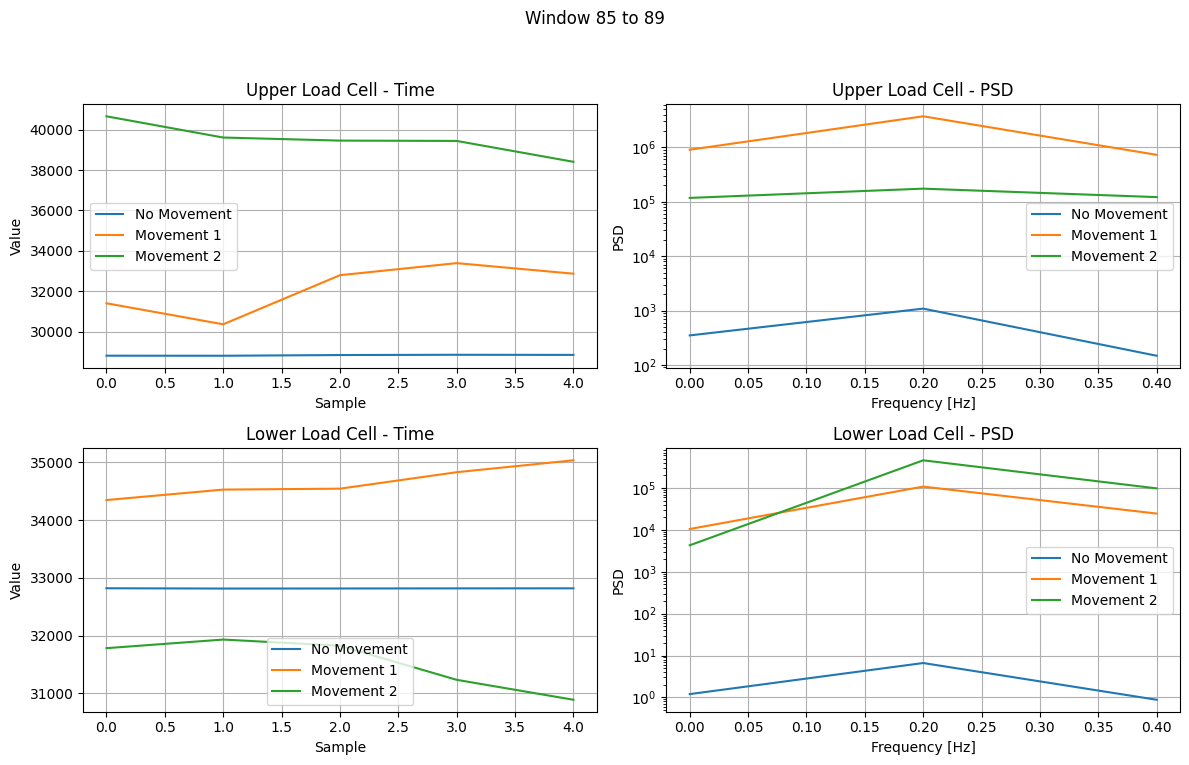

**Interpretation for Window 85-89:**

- **No Movement:**
  - Upper Load Cell: Range 28801.00 to 28849.00, Max PSD 1084.97
  - Lower Load Cell: Range 32816.00 to 32821.00, Max PSD 6.63
- **Movement 1:**
  - Upper Load Cell: Range 30360.00 to 33391.00, Max PSD 3719180.84
  - Lower Load Cell: Range 34348.00 to 35036.00, Max PSD 108253.97
- **Movement 2:**
  - Upper Load Cell: Range 38412.00 to 40667.00, Max PSD 174070.78
  - Lower Load Cell: Range 30891.00 to 31933.00, Max PSD 459609.27

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

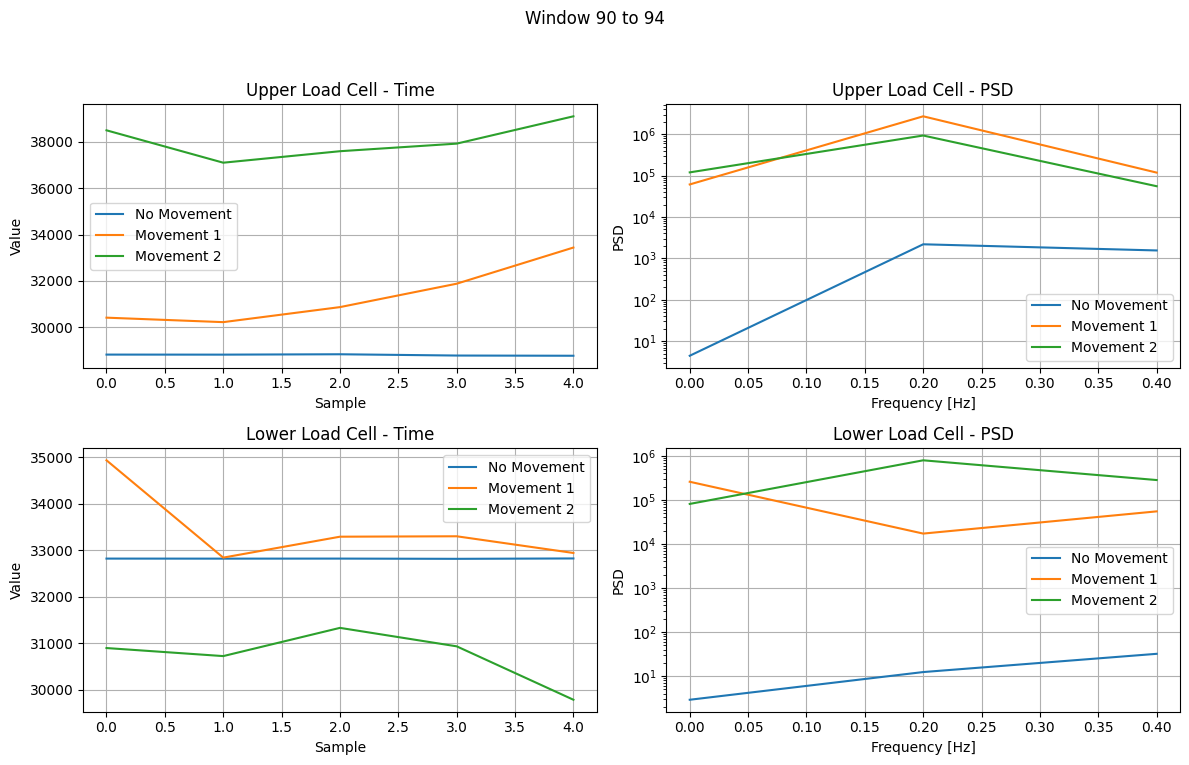

**Interpretation for Window 90-94:**

- **No Movement:**
  - Upper Load Cell: Range 28777.00 to 28841.00, Max PSD 2194.04
  - Lower Load Cell: Range 32813.00 to 32821.00, Max PSD 31.97
- **Movement 1:**
  - Upper Load Cell: Range 30226.00 to 33442.00, Max PSD 2715104.78
  - Lower Load Cell: Range 32839.00 to 34932.00, Max PSD 257059.58
- **Movement 2:**
  - Upper Load Cell: Range 37100.00 to 39100.00, Max PSD 932062.55
  - Lower Load Cell: Range 29782.00 to 31328.00, Max PSD 789008.77

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

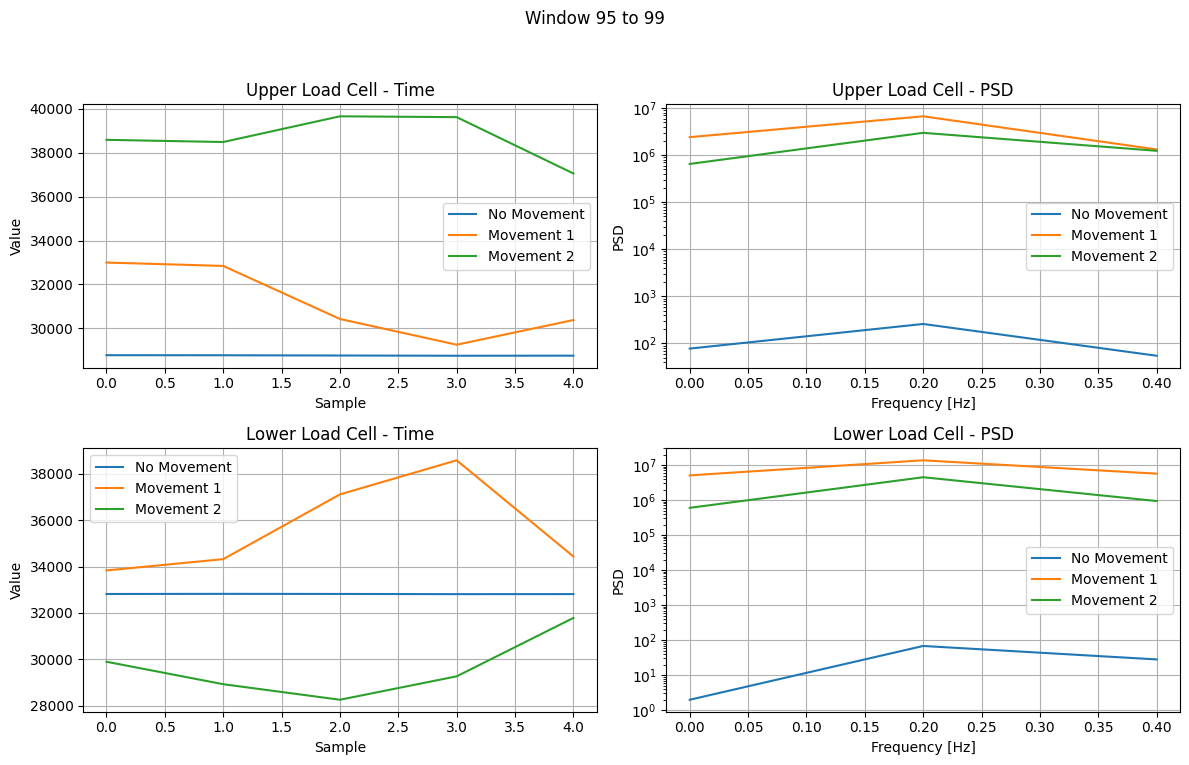

**Interpretation for Window 95-99:**

- **No Movement:**
  - Upper Load Cell: Range 28744.00 to 28769.00, Max PSD 259.14
  - Lower Load Cell: Range 32813.00 to 32825.00, Max PSD 68.06
- **Movement 1:**
  - Upper Load Cell: Range 29247.00 to 32995.00, Max PSD 6699710.78
  - Lower Load Cell: Range 33836.00 to 38590.00, Max PSD 13659504.89
- **Movement 2:**
  - Upper Load Cell: Range 37056.00 to 39664.00, Max PSD 2984692.69
  - Lower Load Cell: Range 28254.00 to 31786.00, Max PSD 4486924.29

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

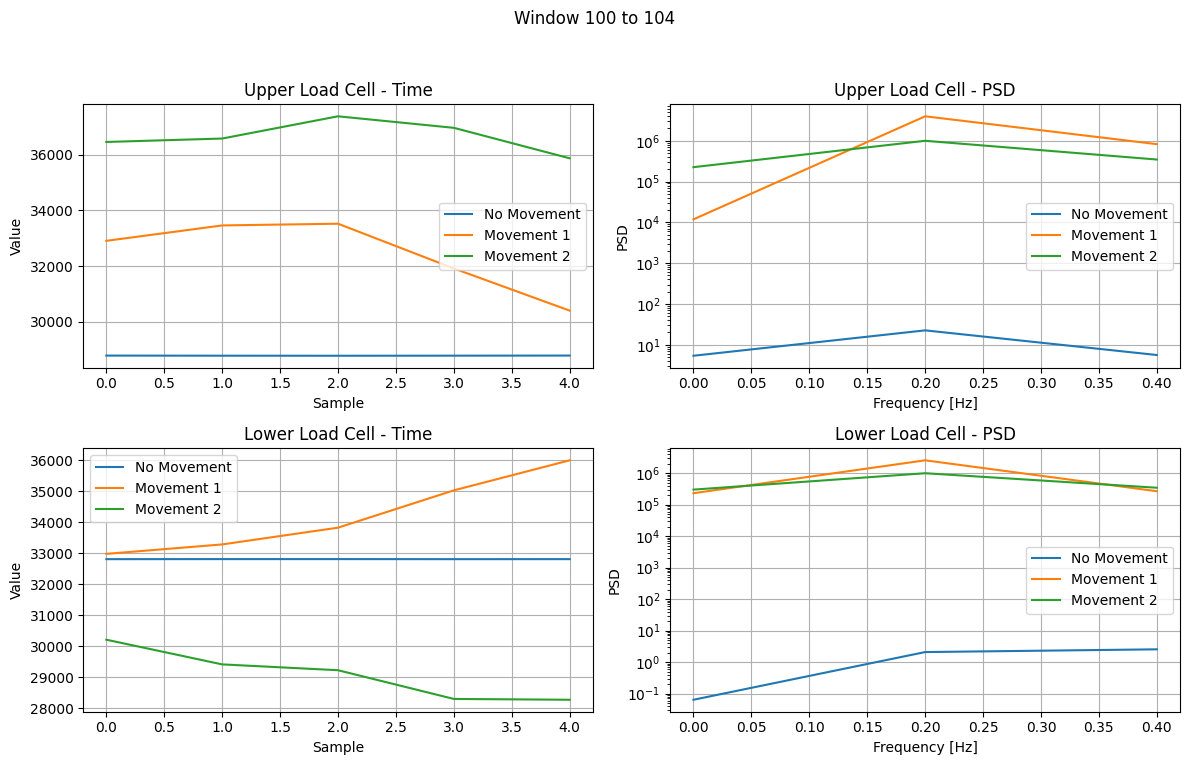

**Interpretation for Window 100-104:**

- **No Movement:**
  - Upper Load Cell: Range 28779.00 to 28786.00, Max PSD 22.56
  - Lower Load Cell: Range 32810.00 to 32812.00, Max PSD 2.54
- **Movement 1:**
  - Upper Load Cell: Range 30400.00 to 33523.00, Max PSD 3976299.57
  - Lower Load Cell: Range 32981.00 to 35997.00, Max PSD 2545528.60
- **Movement 2:**
  - Upper Load Cell: Range 35873.00 to 37382.00, Max PSD 998048.31
  - Lower Load Cell: Range 28278.00 to 30214.00, Max PSD 989365.21

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

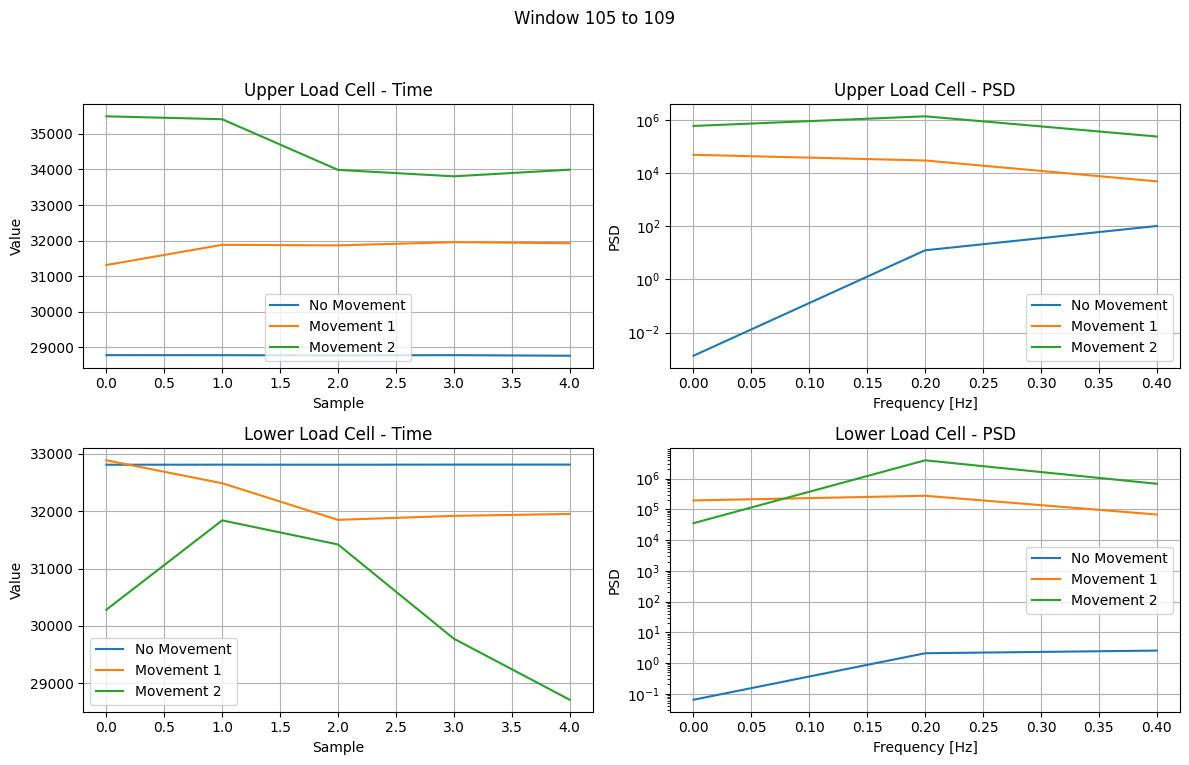

**Interpretation for Window 105-109:**

- **No Movement:**
  - Upper Load Cell: Range 28767.00 to 28784.00, Max PSD 101.76
  - Lower Load Cell: Range 32813.00 to 32815.00, Max PSD 2.54
- **Movement 1:**
  - Upper Load Cell: Range 31315.00 to 31957.00, Max PSD 48243.06
  - Lower Load Cell: Range 31851.00 to 32890.00, Max PSD 277466.17
- **Movement 2:**
  - Upper Load Cell: Range 33808.00 to 35494.00, Max PSD 1346740.70
  - Lower Load Cell: Range 28713.00 to 31842.00, Max PSD 3961579.40

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

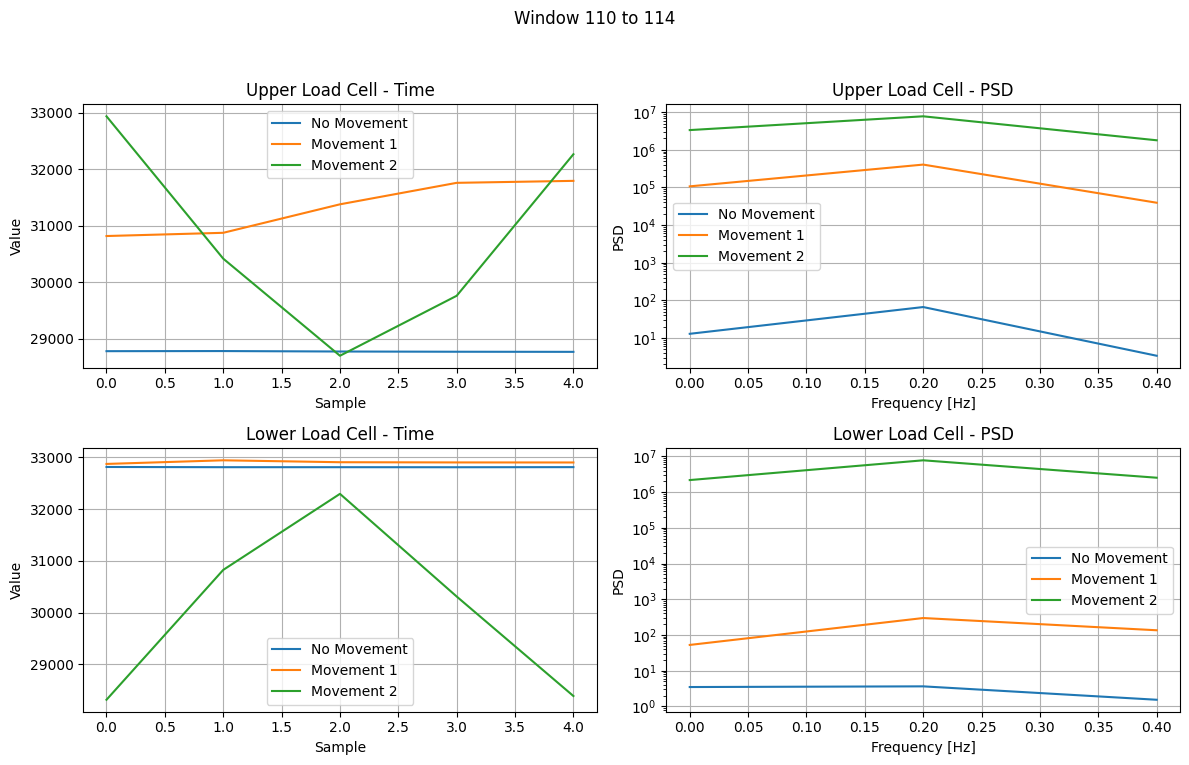

**Interpretation for Window 110-114:**

- **No Movement:**
  - Upper Load Cell: Range 28768.00 to 28782.00, Max PSD 66.55
  - Lower Load Cell: Range 32808.00 to 32813.00, Max PSD 3.65
- **Movement 1:**
  - Upper Load Cell: Range 30817.00 to 31793.00, Max PSD 405427.50
  - Lower Load Cell: Range 32872.00 to 32942.00, Max PSD 298.26
- **Movement 2:**
  - Upper Load Cell: Range 28699.00 to 32935.00, Max PSD 7774791.13
  - Lower Load Cell: Range 28317.00 to 32294.00, Max PSD 7750898.90

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

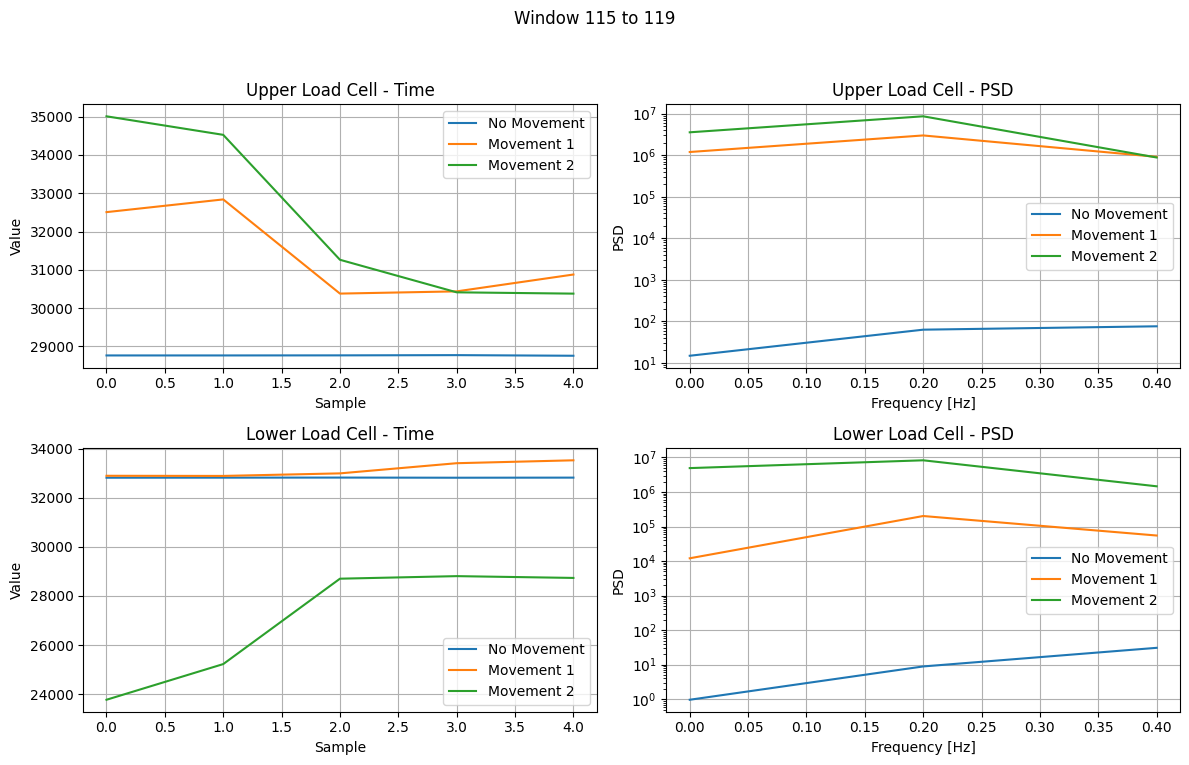

**Interpretation for Window 115-119:**

- **No Movement:**
  - Upper Load Cell: Range 28758.00 to 28774.00, Max PSD 76.12
  - Lower Load Cell: Range 32811.00 to 32817.00, Max PSD 30.78
- **Movement 1:**
  - Upper Load Cell: Range 30381.00 to 32840.00, Max PSD 2993190.51
  - Lower Load Cell: Range 32884.00 to 33520.00, Max PSD 201803.11
- **Movement 2:**
  - Upper Load Cell: Range 30380.00 to 35010.00, Max PSD 8647102.36
  - Lower Load Cell: Range 23773.00 to 28805.00, Max PSD 8281864.02

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

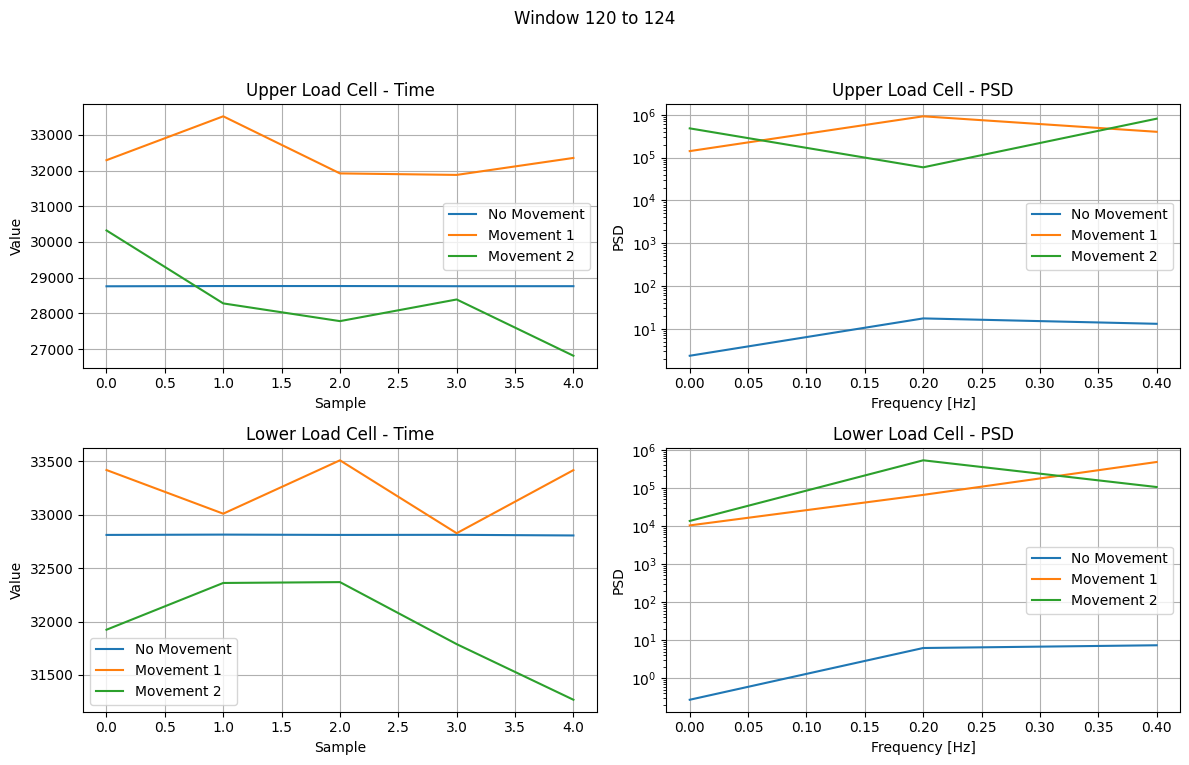

**Interpretation for Window 120-124:**

- **No Movement:**
  - Upper Load Cell: Range 28760.00 to 28767.00, Max PSD 17.46
  - Lower Load Cell: Range 32806.00 to 32814.00, Max PSD 7.34
- **Movement 1:**
  - Upper Load Cell: Range 31877.00 to 33517.00, Max PSD 922913.84
  - Lower Load Cell: Range 32827.00 to 33510.00, Max PSD 480085.16
- **Movement 2:**
  - Upper Load Cell: Range 26816.00 to 30323.00, Max PSD 812165.24
  - Lower Load Cell: Range 31267.00 to 32369.00, Max PSD 531743.59

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

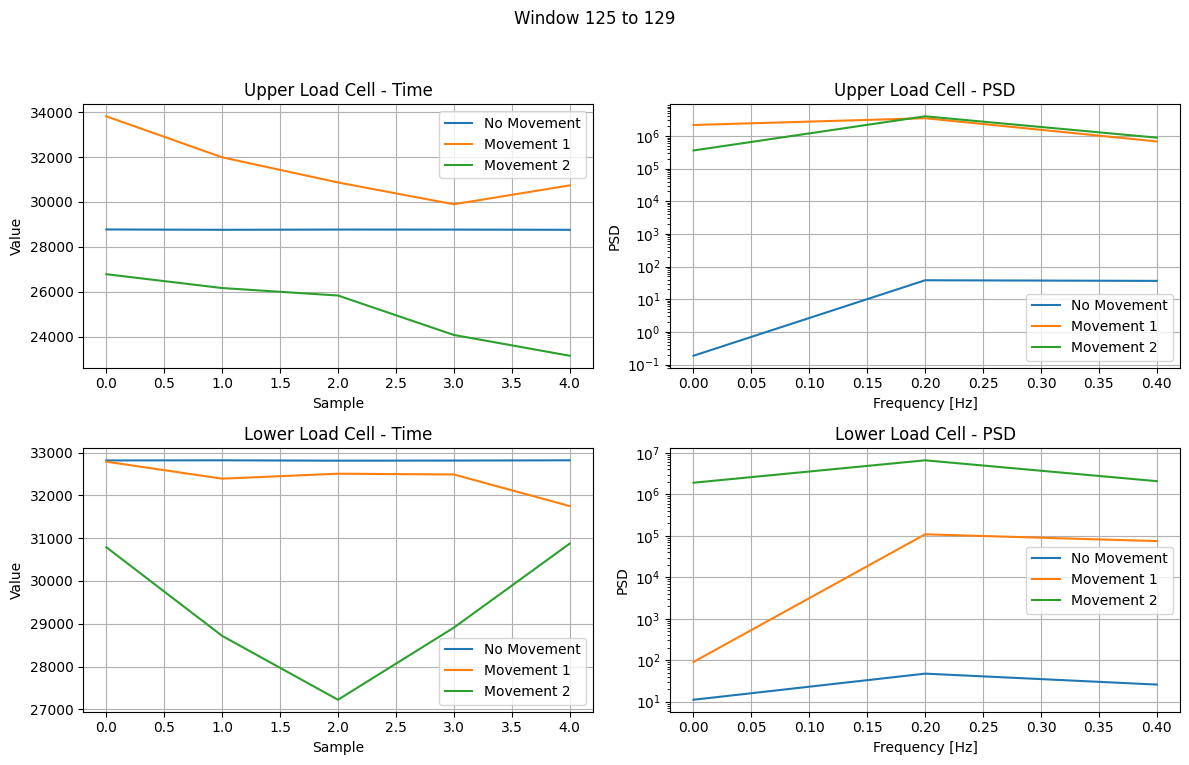

**Interpretation for Window 125-129:**

- **No Movement:**
  - Upper Load Cell: Range 28758.00 to 28773.00, Max PSD 38.15
  - Lower Load Cell: Range 32810.00 to 32819.00, Max PSD 47.45
- **Movement 1:**
  - Upper Load Cell: Range 29895.00 to 33814.00, Max PSD 3508817.65
  - Lower Load Cell: Range 31750.00 to 32787.00, Max PSD 109061.15
- **Movement 2:**
  - Upper Load Cell: Range 23147.00 to 26780.00, Max PSD 4015063.02
  - Lower Load Cell: Range 27224.00 to 30872.00, Max PSD 6648742.19

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

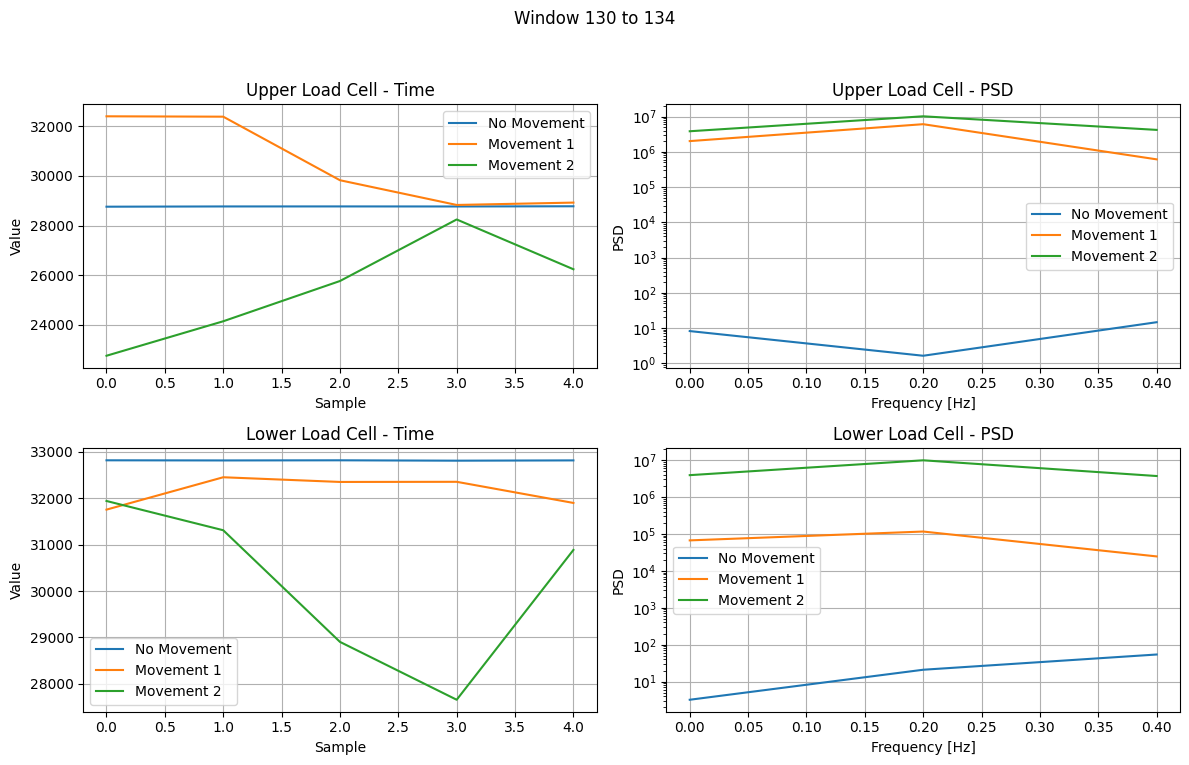

**Interpretation for Window 130-134:**

- **No Movement:**
  - Upper Load Cell: Range 28759.00 to 28776.00, Max PSD 14.61
  - Lower Load Cell: Range 32807.00 to 32815.00, Max PSD 54.29
- **Movement 1:**
  - Upper Load Cell: Range 28829.00 to 32403.00, Max PSD 6112537.51
  - Lower Load Cell: Range 31753.00 to 32450.00, Max PSD 115662.21
- **Movement 2:**
  - Upper Load Cell: Range 22750.00 to 28244.00, Max PSD 10234170.55
  - Lower Load Cell: Range 27659.00 to 31939.00, Max PSD 9798107.36

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

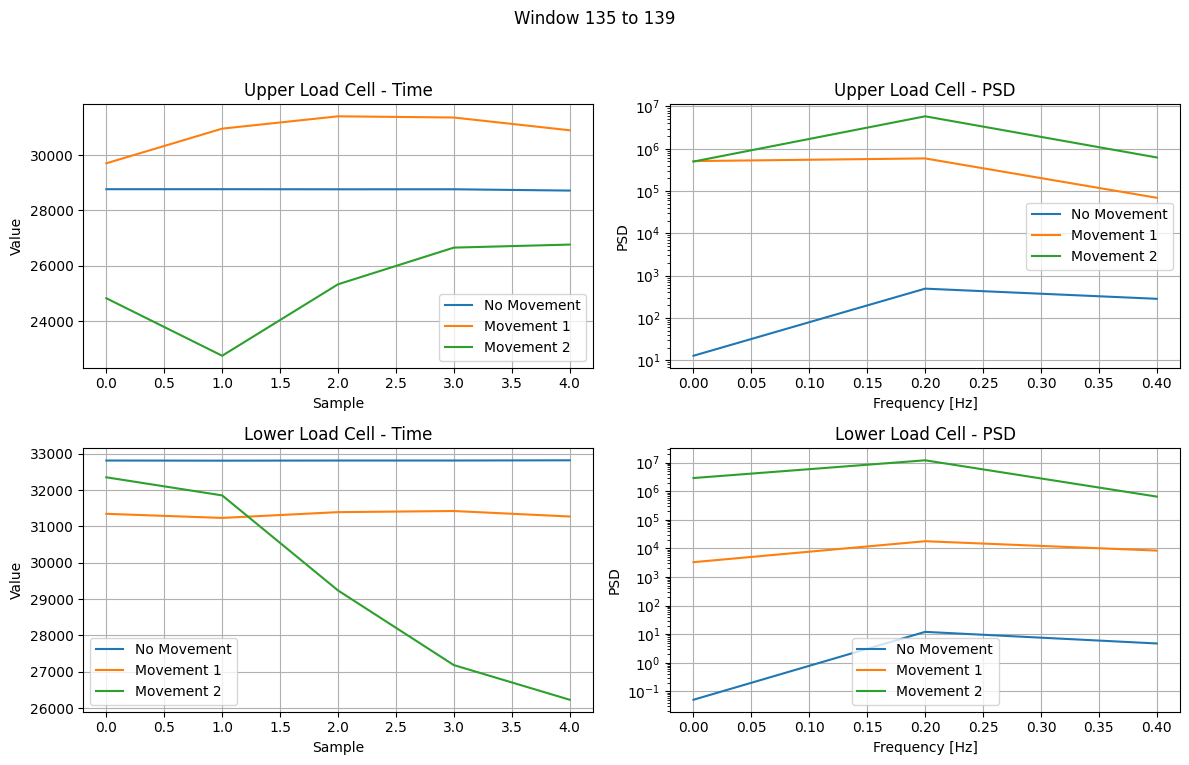

**Interpretation for Window 135-139:**

- **No Movement:**
  - Upper Load Cell: Range 28716.00 to 28766.00, Max PSD 492.79
  - Lower Load Cell: Range 32810.00 to 32820.00, Max PSD 12.06
- **Movement 1:**
  - Upper Load Cell: Range 29702.00 to 31401.00, Max PSD 590540.94
  - Lower Load Cell: Range 31234.00 to 31424.00, Max PSD 17842.20
- **Movement 2:**
  - Upper Load Cell: Range 22745.00 to 26764.00, Max PSD 5846588.21
  - Lower Load Cell: Range 26229.00 to 32352.00, Max PSD 12053203.69

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

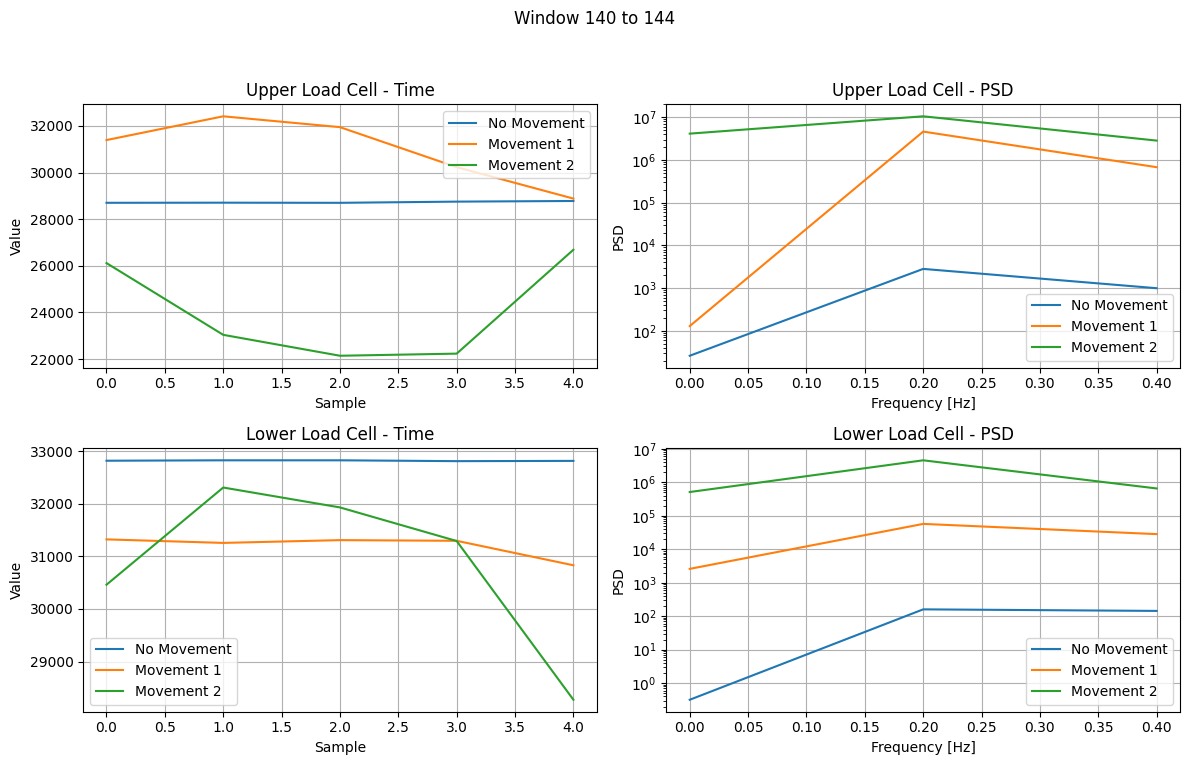

**Interpretation for Window 140-144:**

- **No Movement:**
  - Upper Load Cell: Range 28703.00 to 28782.00, Max PSD 2823.86
  - Lower Load Cell: Range 32808.00 to 32824.00, Max PSD 160.11
- **Movement 1:**
  - Upper Load Cell: Range 28884.00 to 32413.00, Max PSD 4639844.23
  - Lower Load Cell: Range 30830.00 to 31322.00, Max PSD 57347.97
- **Movement 2:**
  - Upper Load Cell: Range 22145.00 to 26691.00, Max PSD 10577953.03
  - Lower Load Cell: Range 28276.00 to 32307.00, Max PSD 4561066.31

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

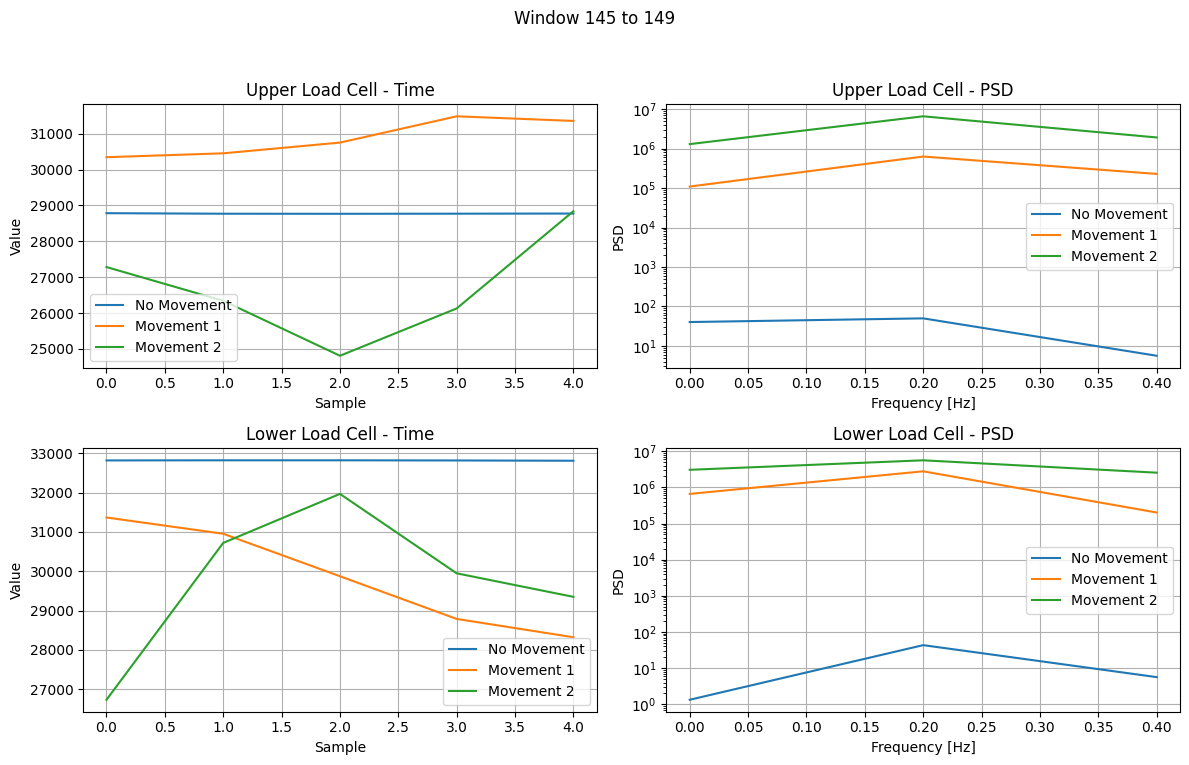

**Interpretation for Window 145-149:**

- **No Movement:**
  - Upper Load Cell: Range 28767.00 to 28784.00, Max PSD 49.78
  - Lower Load Cell: Range 32808.00 to 32819.00, Max PSD 43.21
- **Movement 1:**
  - Upper Load Cell: Range 30345.00 to 31485.00, Max PSD 630323.31
  - Lower Load Cell: Range 28324.00 to 31366.00, Max PSD 2778773.93
- **Movement 2:**
  - Upper Load Cell: Range 24809.00 to 28839.00, Max PSD 6598617.25
  - Lower Load Cell: Range 26736.00 to 31966.00, Max PSD 5604494.17

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

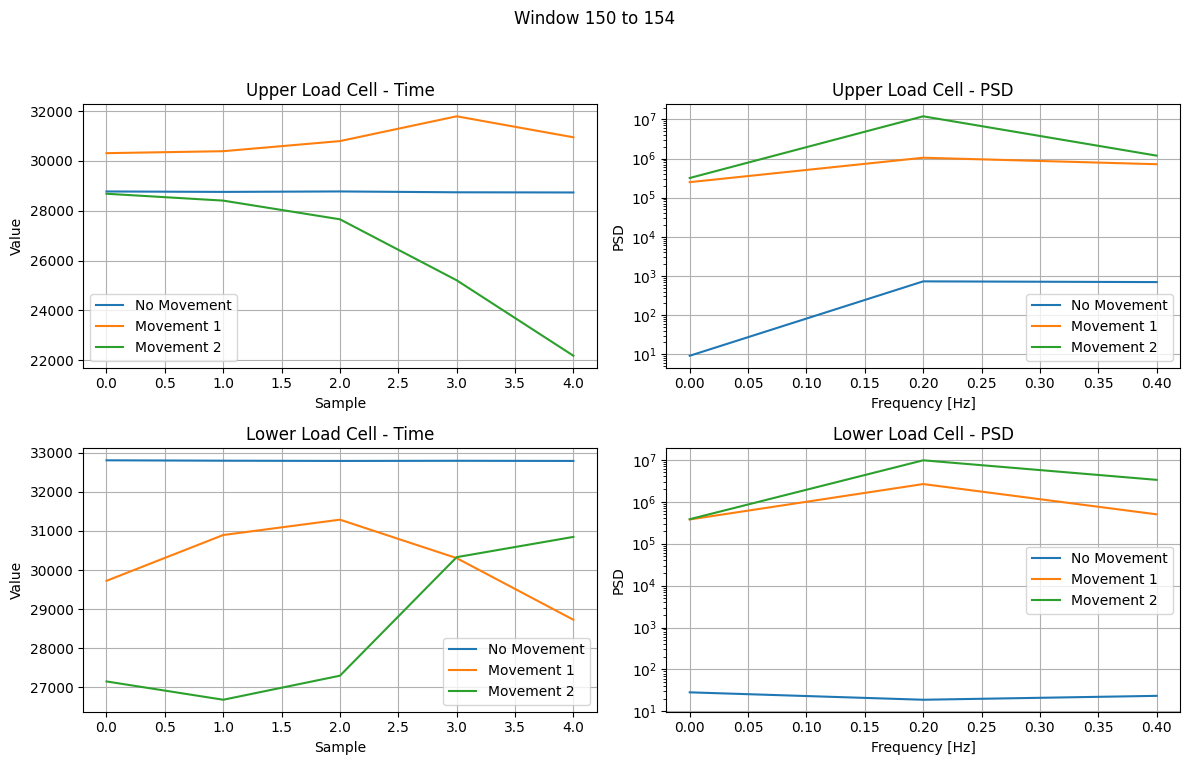

**Interpretation for Window 150-154:**

- **No Movement:**
  - Upper Load Cell: Range 28732.00 to 28773.00, Max PSD 726.70
  - Lower Load Cell: Range 32795.00 to 32811.00, Max PSD 28.49
- **Movement 1:**
  - Upper Load Cell: Range 30309.00 to 31788.00, Max PSD 1049389.85
  - Lower Load Cell: Range 28726.00 to 31290.00, Max PSD 2639853.50
- **Movement 2:**
  - Upper Load Cell: Range 22180.00 to 28681.00, Max PSD 12011700.53
  - Lower Load Cell: Range 26677.00 to 30849.00, Max PSD 9724274.31

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

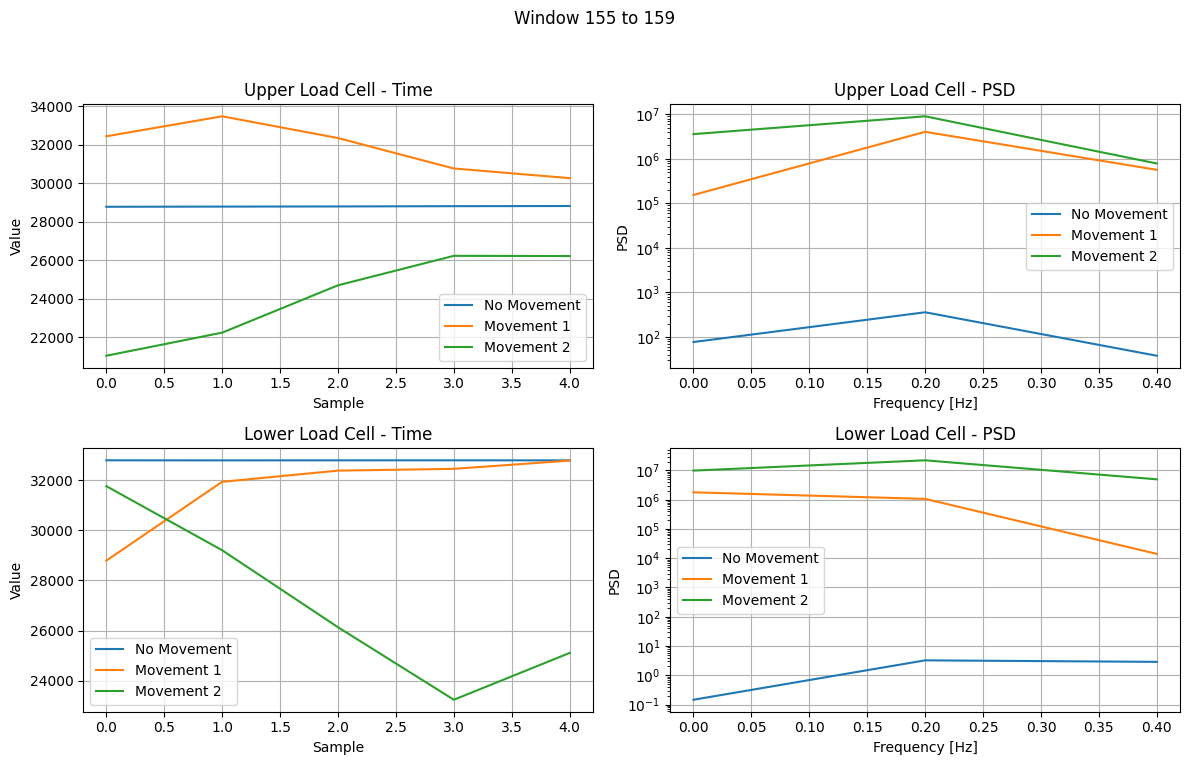

**Interpretation for Window 155-159:**

- **No Movement:**
  - Upper Load Cell: Range 28770.00 to 28809.00, Max PSD 357.67
  - Lower Load Cell: Range 32799.00 to 32802.00, Max PSD 3.24
- **Movement 1:**
  - Upper Load Cell: Range 30256.00 to 33466.00, Max PSD 4037671.05
  - Lower Load Cell: Range 28793.00 to 32790.00, Max PSD 1794048.14
- **Movement 2:**
  - Upper Load Cell: Range 21037.00 to 26224.00, Max PSD 9003594.37
  - Lower Load Cell: Range 23233.00 to 31769.00, Max PSD 22243998.98

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

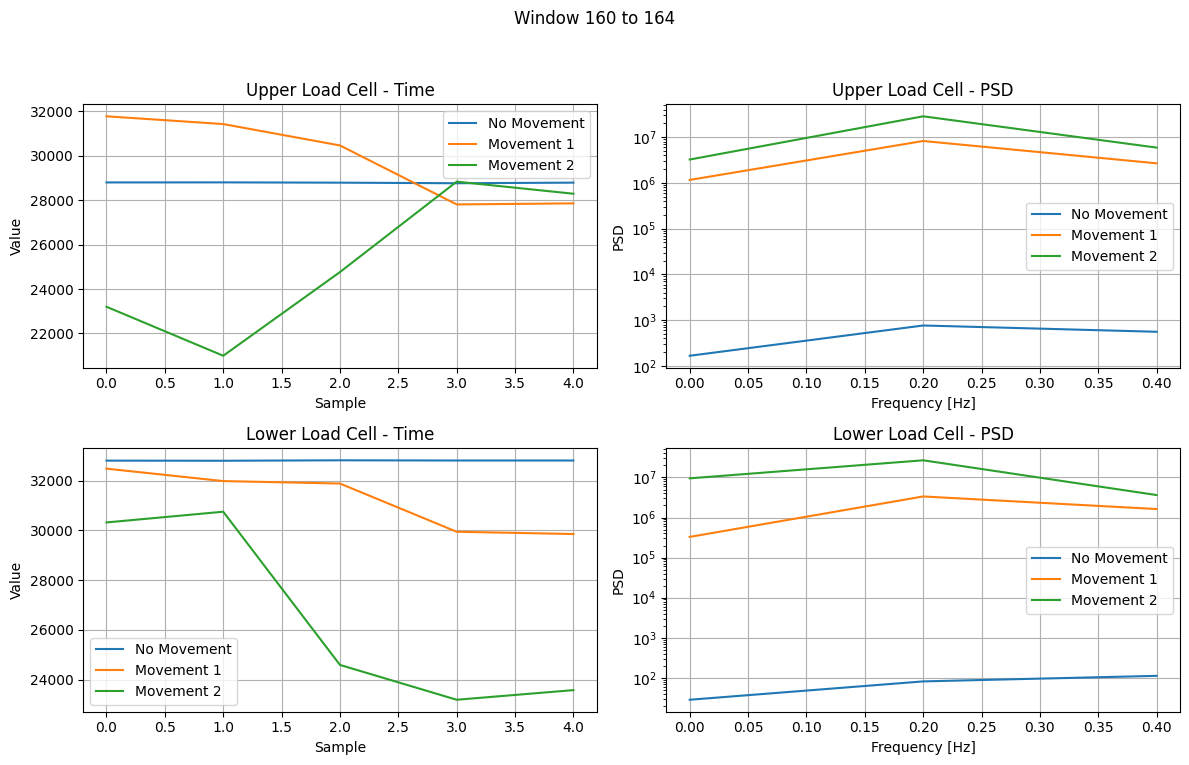

**Interpretation for Window 160-164:**

- **No Movement:**
  - Upper Load Cell: Range 28758.00 to 28797.00, Max PSD 764.22
  - Lower Load Cell: Range 32801.00 to 32819.00, Max PSD 111.73
- **Movement 1:**
  - Upper Load Cell: Range 27805.00 to 31769.00, Max PSD 8224284.89
  - Lower Load Cell: Range 29854.00 to 32483.00, Max PSD 3361992.76
- **Movement 2:**
  - Upper Load Cell: Range 20998.00 to 28829.00, Max PSD 28475767.80
  - Lower Load Cell: Range 23188.00 to 30751.00, Max PSD 26863684.50

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

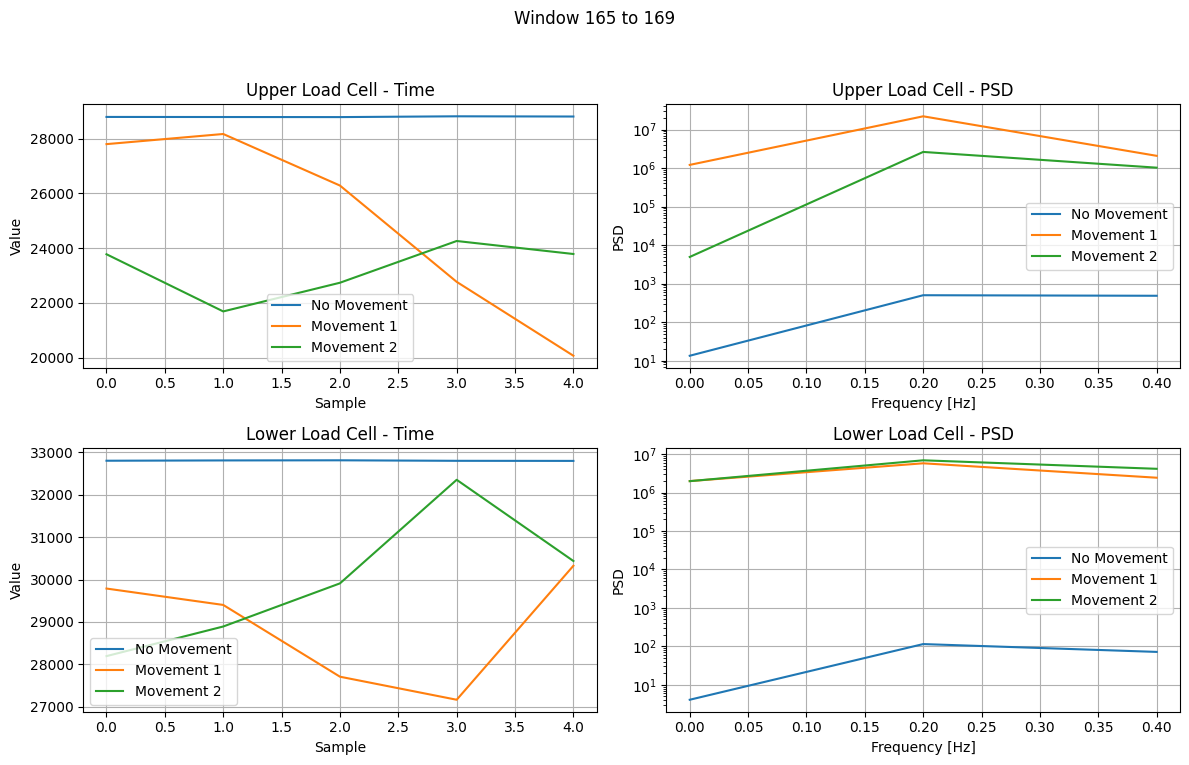

**Interpretation for Window 165-169:**

- **No Movement:**
  - Upper Load Cell: Range 28782.00 to 28811.00, Max PSD 501.71
  - Lower Load Cell: Range 32800.00 to 32814.00, Max PSD 114.81
- **Movement 1:**
  - Upper Load Cell: Range 20066.00 to 28165.00, Max PSD 22194808.22
  - Lower Load Cell: Range 27162.00 to 30325.00, Max PSD 5746639.12
- **Movement 2:**
  - Upper Load Cell: Range 21685.00 to 24257.00, Max PSD 2637202.90
  - Lower Load Cell: Range 28192.00 to 32354.00, Max PSD 6873483.50

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

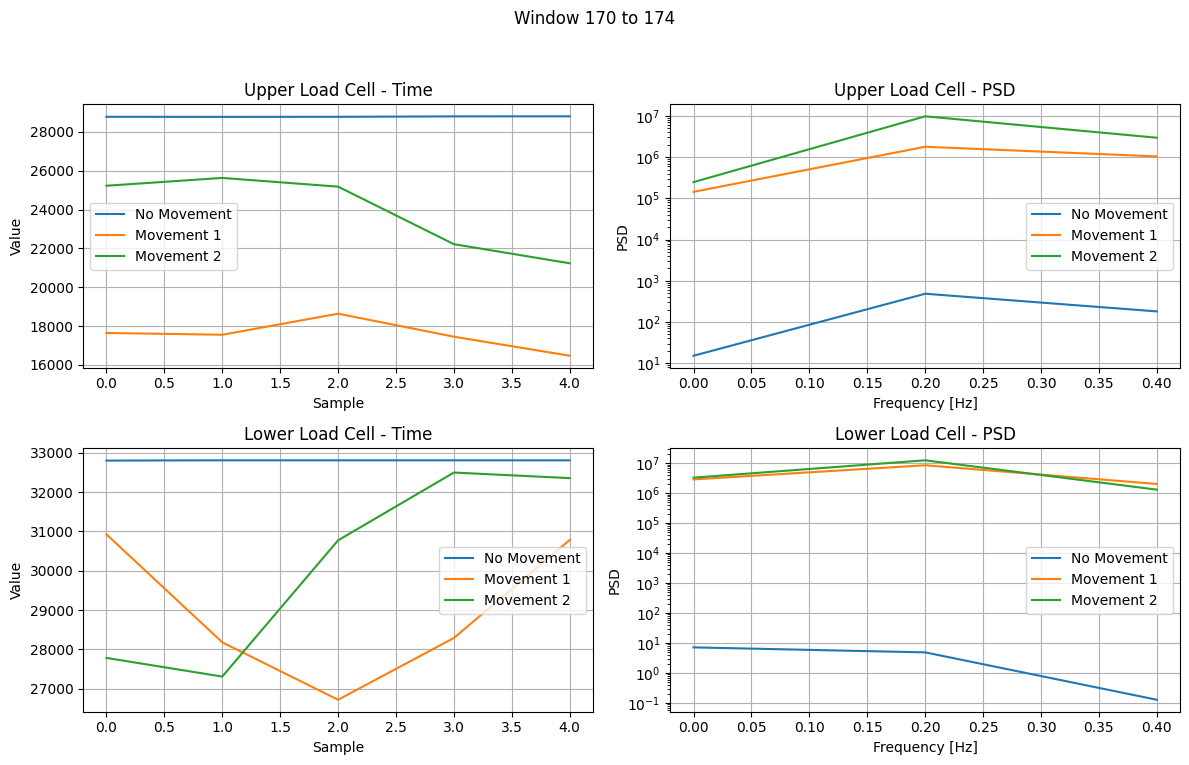

**Interpretation for Window 170-174:**

- **No Movement:**
  - Upper Load Cell: Range 28779.00 to 28808.00, Max PSD 486.66
  - Lower Load Cell: Range 32800.00 to 32807.00, Max PSD 7.12
- **Movement 1:**
  - Upper Load Cell: Range 16467.00 to 18635.00, Max PSD 1785834.12
  - Lower Load Cell: Range 26721.00 to 30925.00, Max PSD 8515049.35
- **Movement 2:**
  - Upper Load Cell: Range 21233.00 to 25632.00, Max PSD 9782486.36
  - Lower Load Cell: Range 27310.00 to 32496.00, Max PSD 12457969.71

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

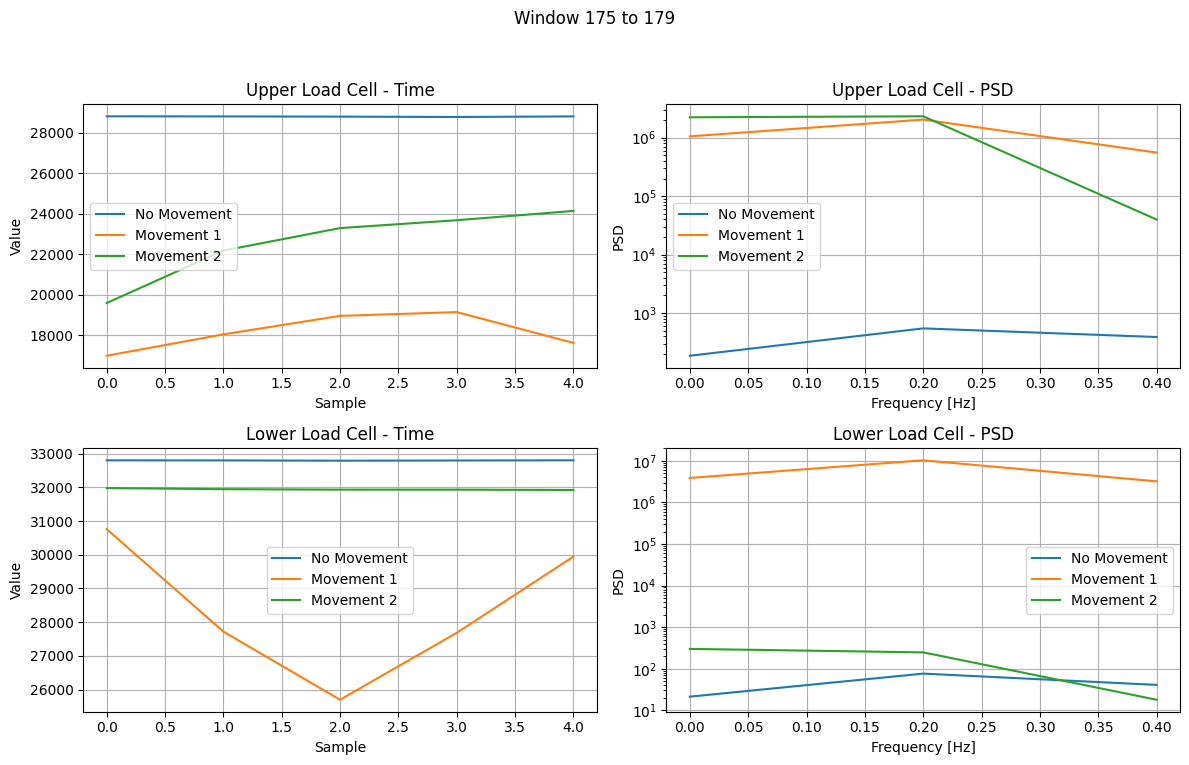

**Interpretation for Window 175-179:**

- **No Movement:**
  - Upper Load Cell: Range 28777.00 to 28811.00, Max PSD 546.85
  - Lower Load Cell: Range 32791.00 to 32803.00, Max PSD 76.25
- **Movement 1:**
  - Upper Load Cell: Range 16997.00 to 19150.00, Max PSD 2039767.67
  - Lower Load Cell: Range 25699.00 to 30763.00, Max PSD 10319792.45
- **Movement 2:**
  - Upper Load Cell: Range 19597.00 to 24142.00, Max PSD 2322622.06
  - Lower Load Cell: Range 31922.00 to 31979.00, Max PSD 299.91

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

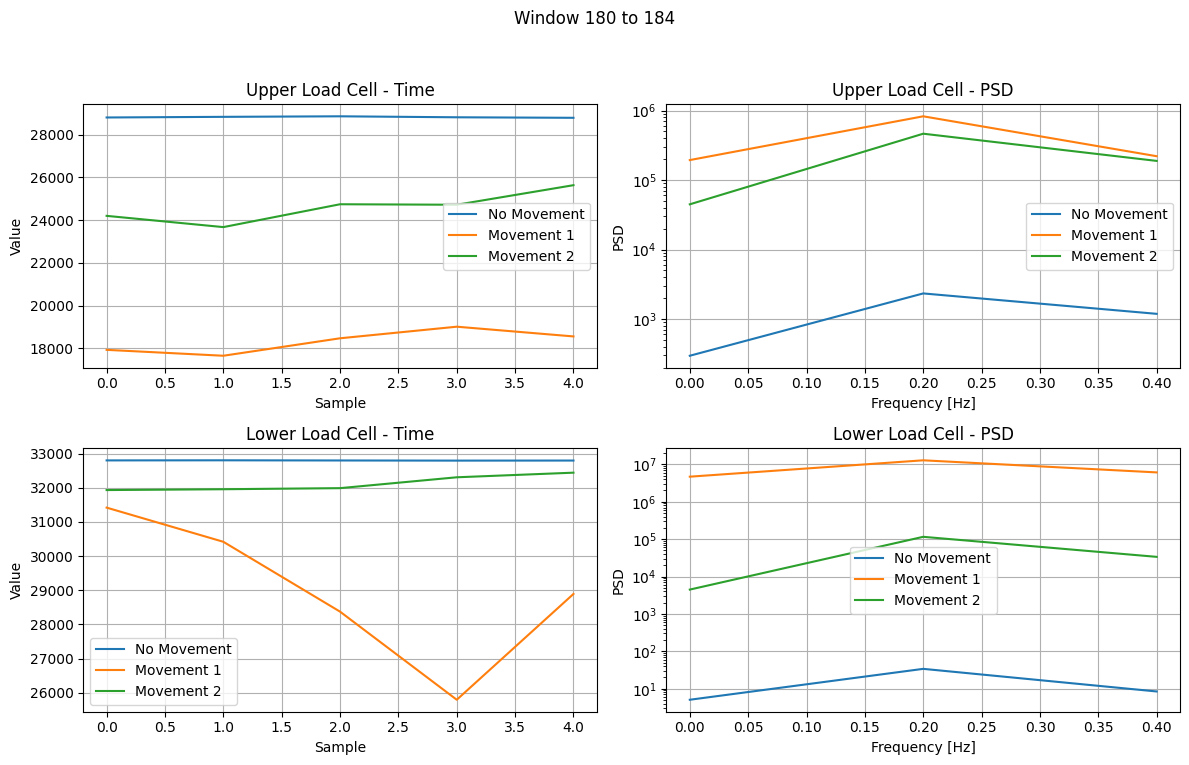

**Interpretation for Window 180-184:**

- **No Movement:**
  - Upper Load Cell: Range 28783.00 to 28853.00, Max PSD 2335.22
  - Lower Load Cell: Range 32794.00 to 32803.00, Max PSD 33.95
- **Movement 1:**
  - Upper Load Cell: Range 17652.00 to 19011.00, Max PSD 825433.12
  - Lower Load Cell: Range 25794.00 to 31418.00, Max PSD 12824543.17
- **Movement 2:**
  - Upper Load Cell: Range 23670.00 to 25631.00, Max PSD 463842.23
  - Lower Load Cell: Range 31932.00 to 32441.00, Max PSD 115365.10

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

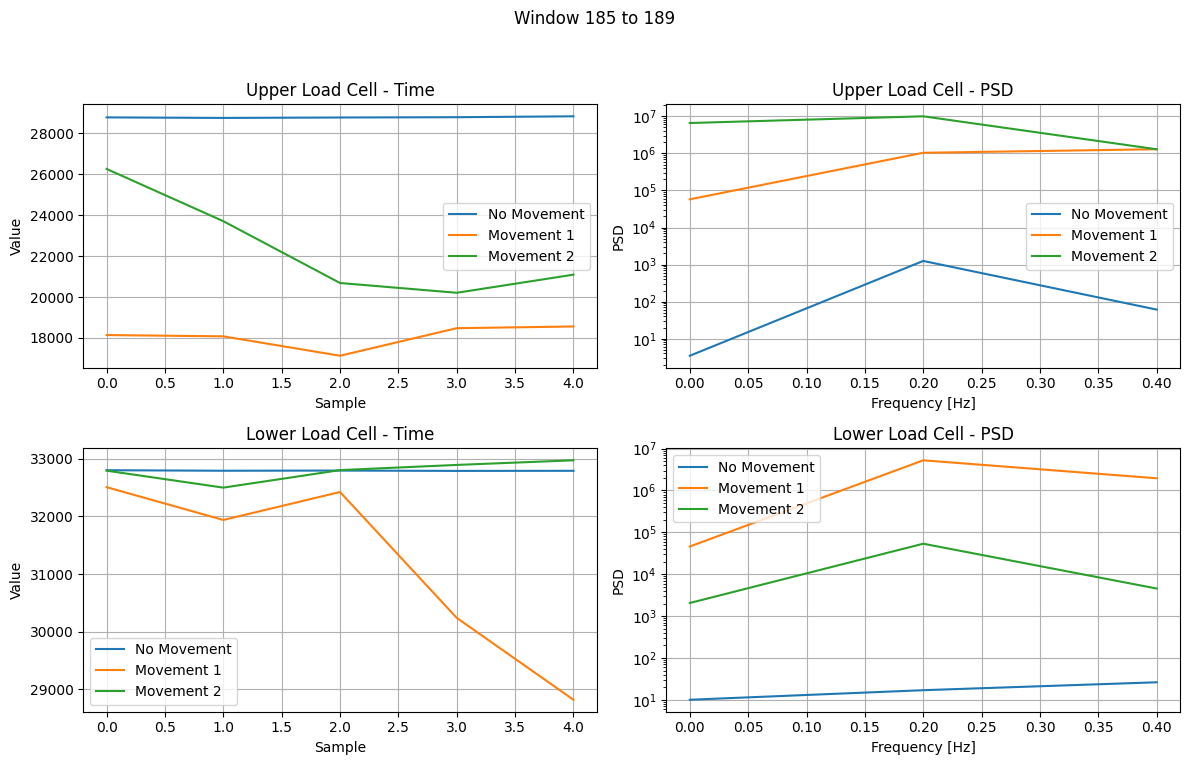

**Interpretation for Window 185-189:**

- **No Movement:**
  - Upper Load Cell: Range 28758.00 to 28837.00, Max PSD 1253.35
  - Lower Load Cell: Range 32789.00 to 32801.00, Max PSD 26.31
- **Movement 1:**
  - Upper Load Cell: Range 17129.00 to 18560.00, Max PSD 1291150.66
  - Lower Load Cell: Range 28819.00 to 32507.00, Max PSD 5255728.19
- **Movement 2:**
  - Upper Load Cell: Range 20208.00 to 26263.00, Max PSD 9974695.28
  - Lower Load Cell: Range 32499.00 to 32973.00, Max PSD 53573.14

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

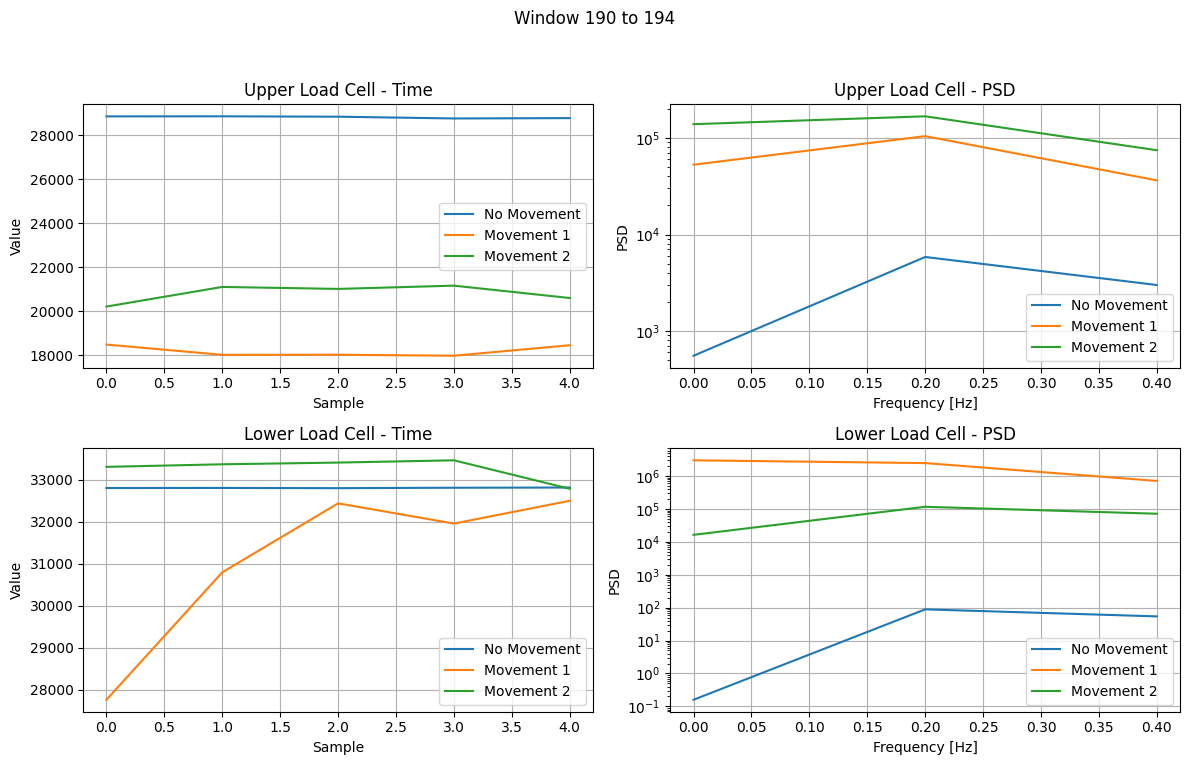

**Interpretation for Window 190-194:**

- **No Movement:**
  - Upper Load Cell: Range 28754.00 to 28852.00, Max PSD 5849.43
  - Lower Load Cell: Range 32794.00 to 32809.00, Max PSD 88.97
- **Movement 1:**
  - Upper Load Cell: Range 17986.00 to 18493.00, Max PSD 104395.35
  - Lower Load Cell: Range 27757.00 to 32494.00, Max PSD 3038556.37
- **Movement 2:**
  - Upper Load Cell: Range 20218.00 to 21167.00, Max PSD 167574.32
  - Lower Load Cell: Range 32779.00 to 33457.00, Max PSD 117232.10

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

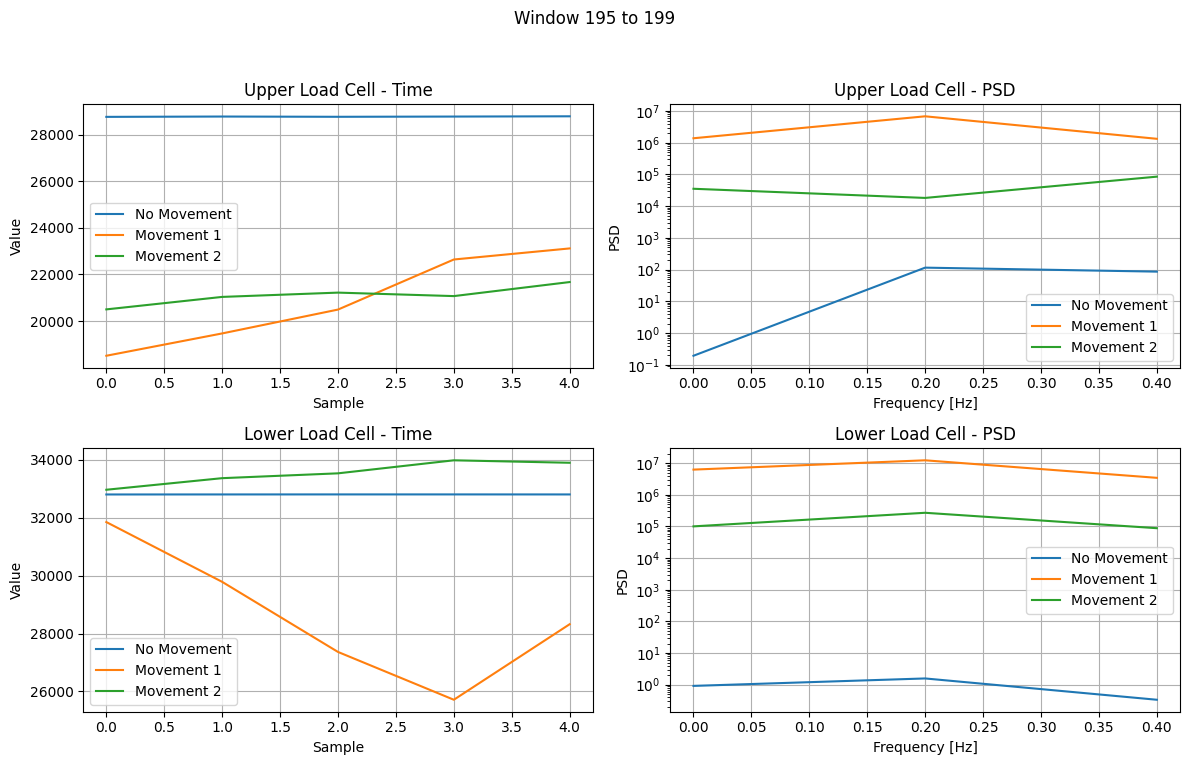

**Interpretation for Window 195-199:**

- **No Movement:**
  - Upper Load Cell: Range 28759.00 to 28783.00, Max PSD 115.42
  - Lower Load Cell: Range 32805.00 to 32807.00, Max PSD 1.57
- **Movement 1:**
  - Upper Load Cell: Range 18516.00 to 23118.00, Max PSD 6817138.40
  - Lower Load Cell: Range 25715.00 to 31852.00, Max PSD 12367785.77
- **Movement 2:**
  - Upper Load Cell: Range 20504.00 to 21676.00, Max PSD 85305.80
  - Lower Load Cell: Range 32968.00 to 33985.00, Max PSD 271282.32

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

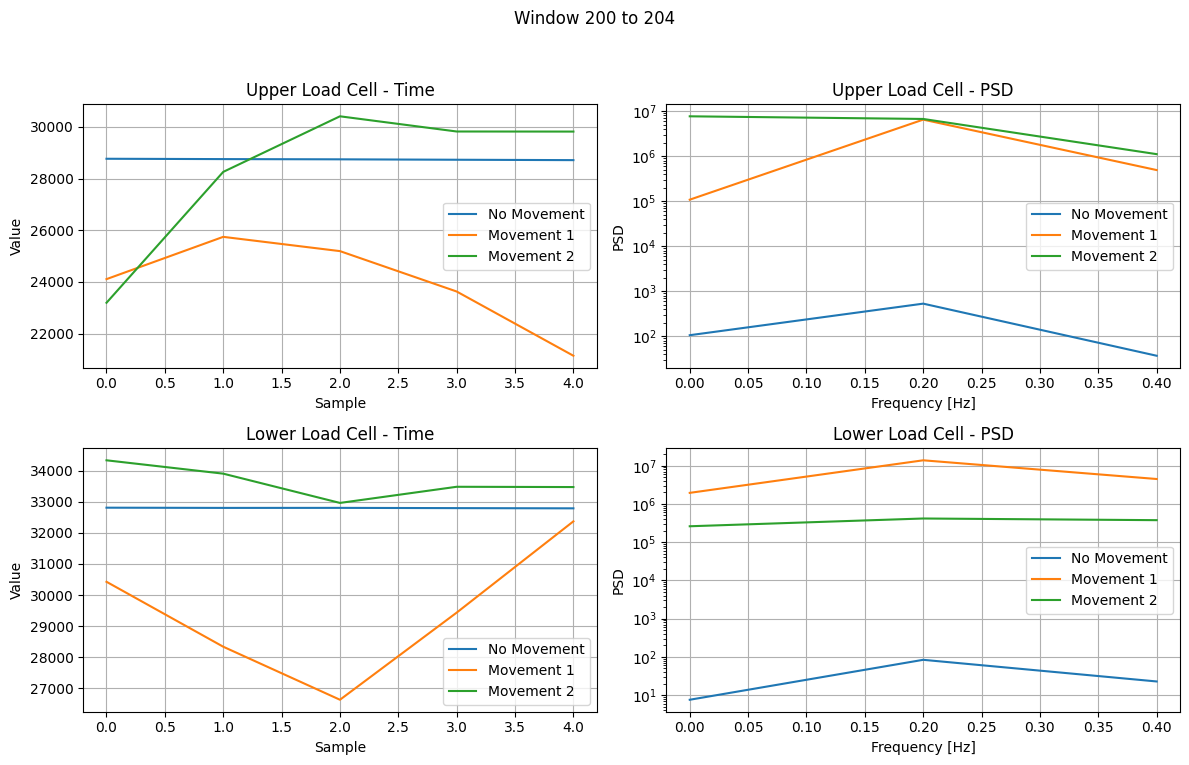

**Interpretation for Window 200-204:**

- **No Movement:**
  - Upper Load Cell: Range 28715.00 to 28768.00, Max PSD 530.60
  - Lower Load Cell: Range 32789.00 to 32810.00, Max PSD 83.74
- **Movement 1:**
  - Upper Load Cell: Range 21145.00 to 25746.00, Max PSD 6479777.54
  - Lower Load Cell: Range 26636.00 to 32371.00, Max PSD 13856552.01
- **Movement 2:**
  - Upper Load Cell: Range 23195.00 to 30411.00, Max PSD 7676268.91
  - Lower Load Cell: Range 32963.00 to 34333.00, Max PSD 416315.18

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

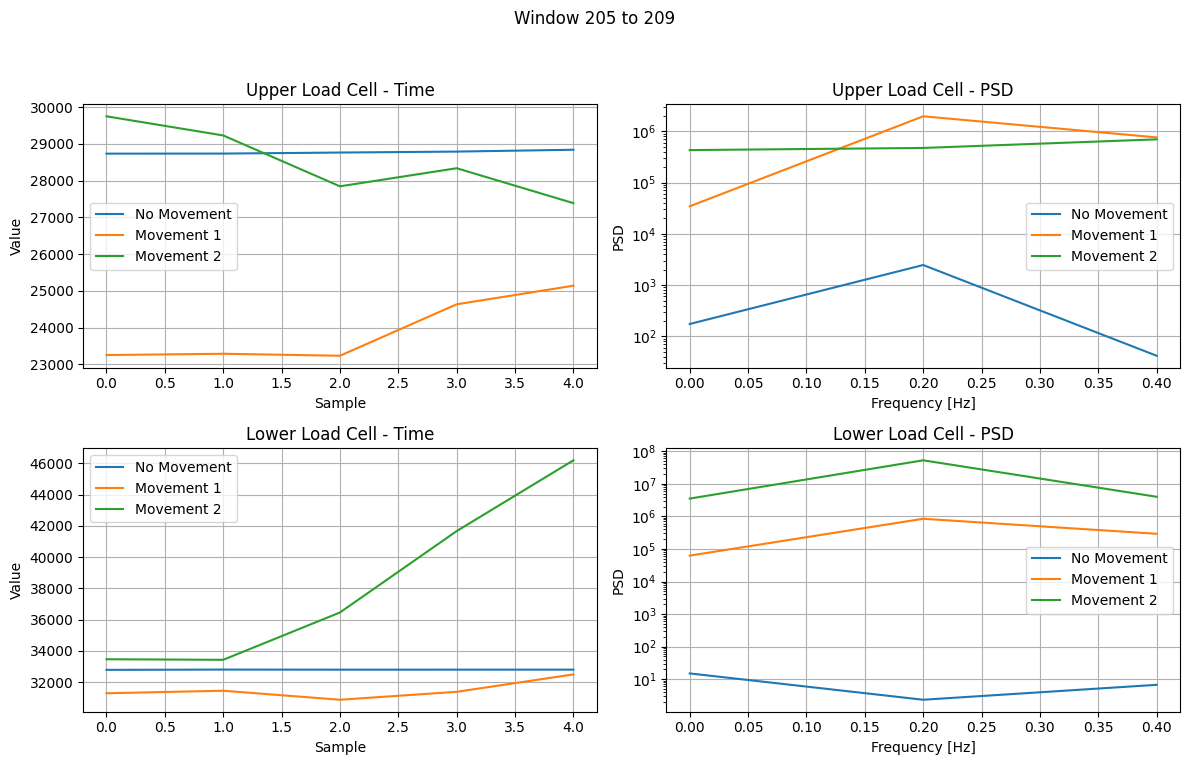

**Interpretation for Window 205-209:**

- **No Movement:**
  - Upper Load Cell: Range 28733.00 to 28839.00, Max PSD 2466.13
  - Lower Load Cell: Range 32792.00 to 32810.00, Max PSD 15.11
- **Movement 1:**
  - Upper Load Cell: Range 23234.00 to 25140.00, Max PSD 1953156.56
  - Lower Load Cell: Range 30881.00 to 32502.00, Max PSD 842142.61
- **Movement 2:**
  - Upper Load Cell: Range 27386.00 to 29749.00, Max PSD 693764.89
  - Lower Load Cell: Range 33434.00 to 46188.00, Max PSD 52429037.61

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

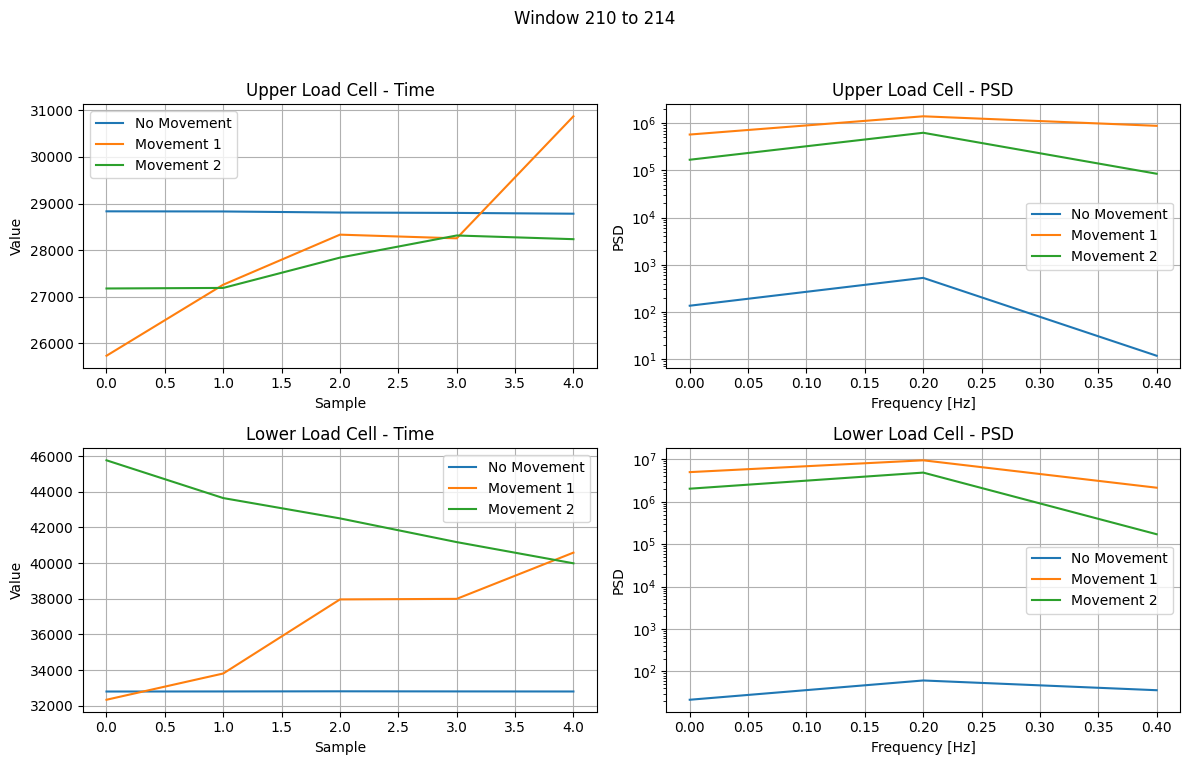

**Interpretation for Window 210-214:**

- **No Movement:**
  - Upper Load Cell: Range 28782.00 to 28833.00, Max PSD 526.88
  - Lower Load Cell: Range 32803.00 to 32815.00, Max PSD 61.29
- **Movement 1:**
  - Upper Load Cell: Range 25737.00 to 30870.00, Max PSD 1404805.11
  - Lower Load Cell: Range 32342.00 to 40587.00, Max PSD 9488144.67
- **Movement 2:**
  - Upper Load Cell: Range 27179.00 to 28315.00, Max PSD 628831.68
  - Lower Load Cell: Range 39989.00 to 45761.00, Max PSD 4870570.22

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

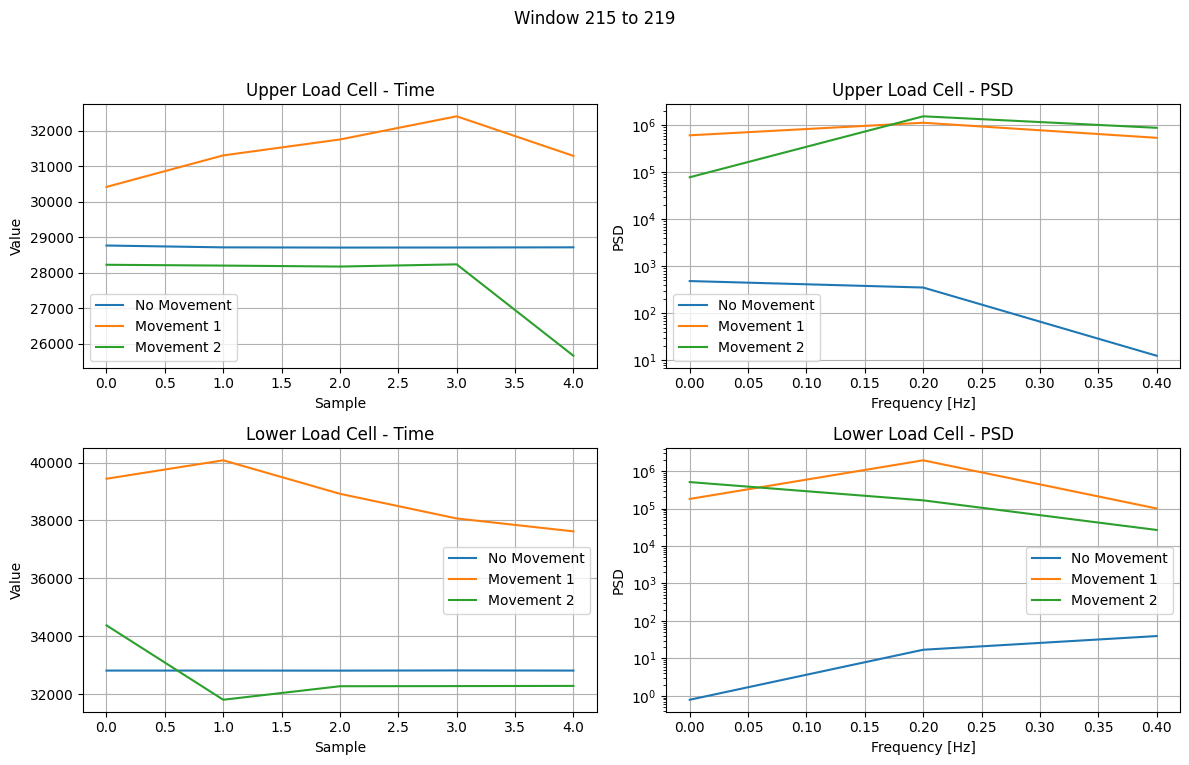

**Interpretation for Window 215-219:**

- **No Movement:**
  - Upper Load Cell: Range 28707.00 to 28765.00, Max PSD 486.41
  - Lower Load Cell: Range 32810.00 to 32817.00, Max PSD 39.43
- **Movement 1:**
  - Upper Load Cell: Range 30414.00 to 32401.00, Max PSD 1133625.31
  - Lower Load Cell: Range 37621.00 to 40076.00, Max PSD 1948745.26
- **Movement 2:**
  - Upper Load Cell: Range 25663.00 to 28235.00, Max PSD 1553952.38
  - Lower Load Cell: Range 31804.00 to 34374.00, Max PSD 511191.07

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

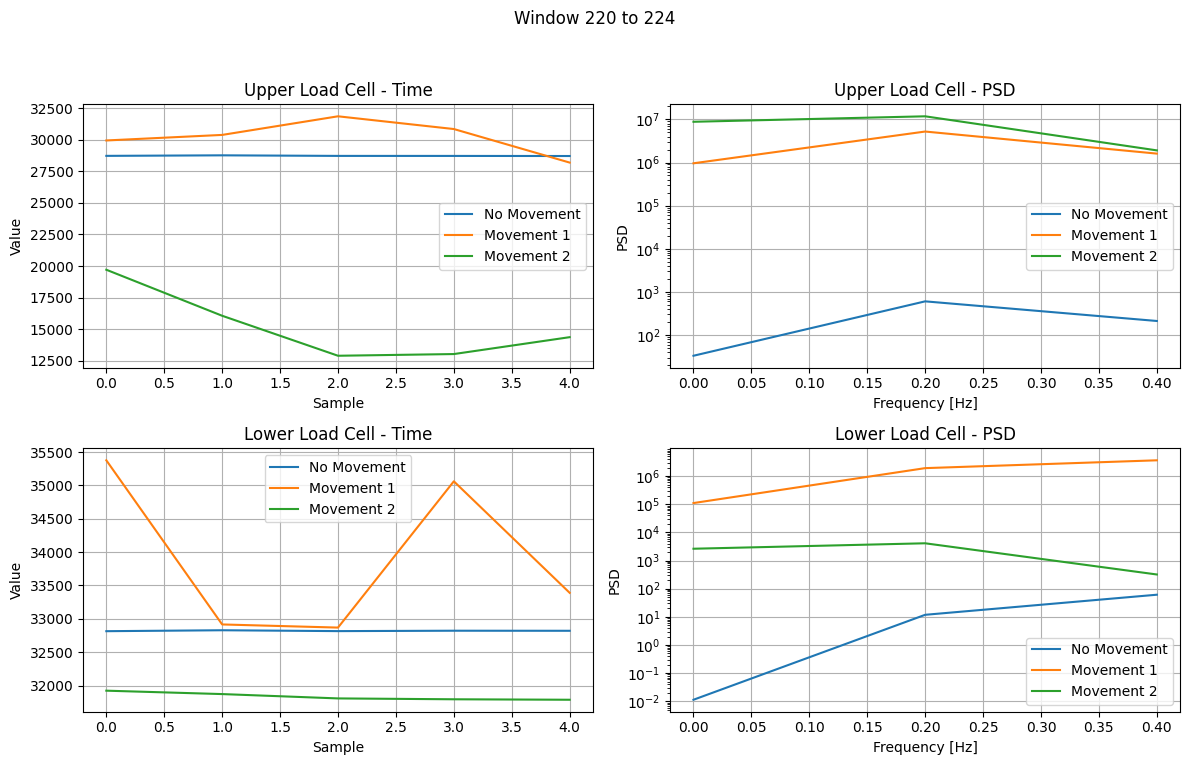

**Interpretation for Window 220-224:**

- **No Movement:**
  - Upper Load Cell: Range 28704.00 to 28758.00, Max PSD 603.31
  - Lower Load Cell: Range 32815.00 to 32829.00, Max PSD 61.12
- **Movement 1:**
  - Upper Load Cell: Range 28184.00 to 31845.00, Max PSD 5227374.32
  - Lower Load Cell: Range 32869.00 to 35377.00, Max PSD 3638698.24
- **Movement 2:**
  - Upper Load Cell: Range 12905.00 to 19708.00, Max PSD 11790175.01
  - Lower Load Cell: Range 31787.00 to 31923.00, Max PSD 4103.84

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

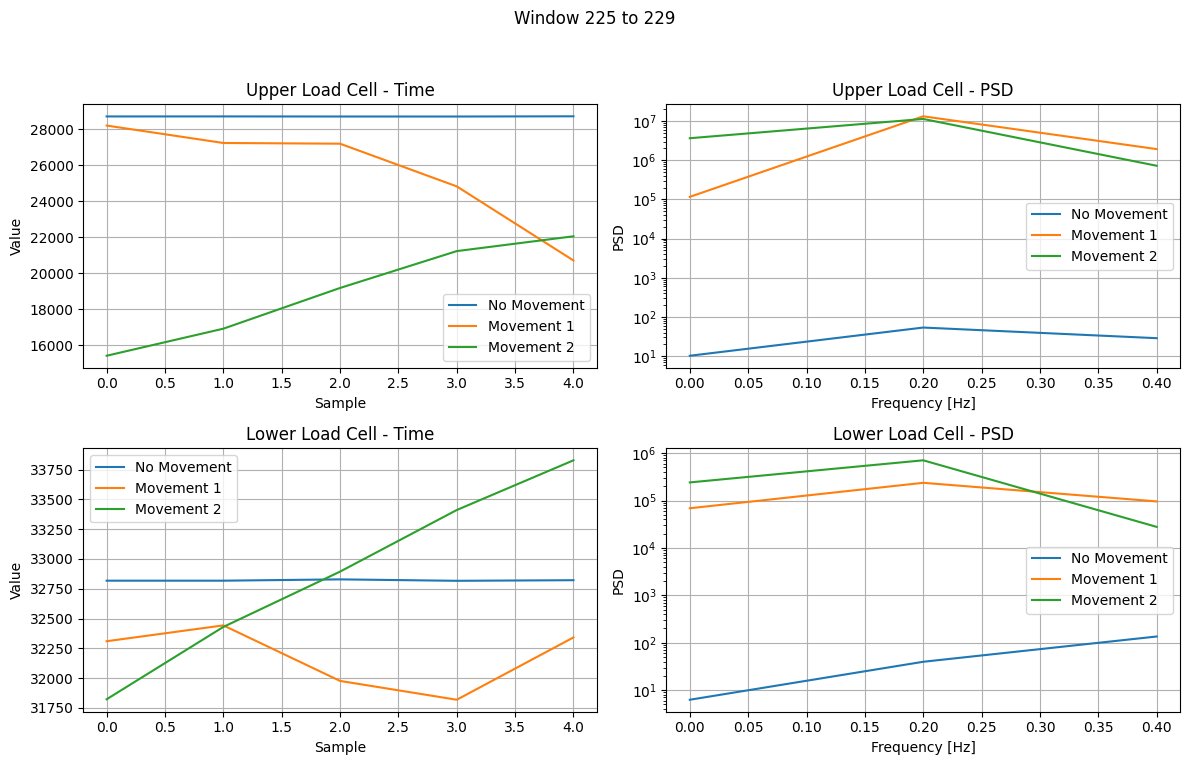

**Interpretation for Window 225-229:**

- **No Movement:**
  - Upper Load Cell: Range 28700.00 to 28712.00, Max PSD 53.59
  - Lower Load Cell: Range 32817.00 to 32829.00, Max PSD 135.26
- **Movement 1:**
  - Upper Load Cell: Range 20713.00 to 28199.00, Max PSD 13210755.17
  - Lower Load Cell: Range 31819.00 to 32443.00, Max PSD 236289.88
- **Movement 2:**
  - Upper Load Cell: Range 15427.00 to 22055.00, Max PSD 11307310.83
  - Lower Load Cell: Range 31823.00 to 33828.00, Max PSD 705051.48

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

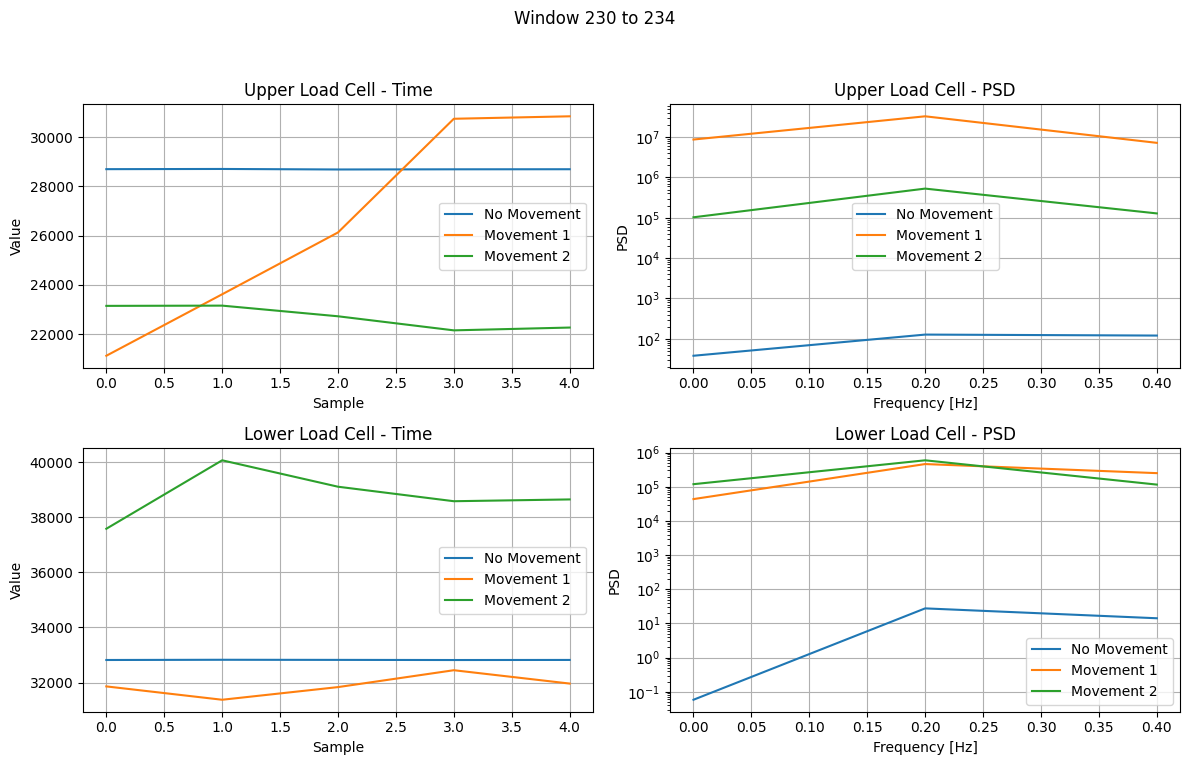

**Interpretation for Window 230-234:**

- **No Movement:**
  - Upper Load Cell: Range 28691.00 to 28712.00, Max PSD 127.61
  - Lower Load Cell: Range 32819.00 to 32828.00, Max PSD 27.67
- **Movement 1:**
  - Upper Load Cell: Range 21121.00 to 30852.00, Max PSD 32638847.58
  - Lower Load Cell: Range 31378.00 to 32449.00, Max PSD 462902.46
- **Movement 2:**
  - Upper Load Cell: Range 22153.00 to 23158.00, Max PSD 527935.96
  - Lower Load Cell: Range 37580.00 to 40063.00, Max PSD 596082.88

- Compare the range and PSD values across movement types. Larger ranges or higher PSDs suggest more dynamic or energetic activity in that window. If upper and lower load cells differ, it may indicate uneven load distribution or movement pattern.

In [ ]:
# sliding_window_plot_all_step_interpret(df_no, df_1, df_2, col, col2, window_size=5)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem  # Standard error of the mean

def plot_mean_sem_across_windows(df_no, df_1, df_2, col, col2, window_size=5):
    """
    Plot mean ± SEM for upper and lower load cell signals across all windows,
    for three movement types, with different color shades.
    """
    dfs = {'No Movement': df_no, 'Movement 1': df_1, 'Movement 2': df_2}
    colors = {'No Movement': 'tab:blue', 'Movement 1': 'tab:orange', 'Movement 2': 'tab:green'}
    n_windows = min(len(df_no) // window_size, len(df_1) // window_size, len(df_2) // window_size)
    time_points = np.arange(window_size)

    # Prepare containers for all windowed segments
    data = {label: {'upper': [], 'lower': []} for label in dfs}
    for label, df in dfs.items():
        for i in range(n_windows):
            start = i * window_size
            end = start + window_size
            data[label]['upper'].append(df[col].iloc[start:end].values)
            data[label]['lower'].append(df[col2].iloc[start:end].values)
        data[label]['upper'] = np.stack(data[label]['upper'])
        data[label]['lower'] = np.stack(data[label]['lower'])

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    for label in dfs:
        # Upper
        mean_upper = np.mean(data[label]['upper'], axis=0)
        sem_upper = sem(data[label]['upper'], axis=0)
        axs[0].plot(time_points, mean_upper, label=label, color=colors[label])
        axs[0].fill_between(time_points, mean_upper - sem_upper, mean_upper + sem_upper,
                            color=colors[label], alpha=0.2)
        # Lower
        mean_lower = np.mean(data[label]['lower'], axis=0)
        sem_lower = sem(data[label]['lower'], axis=0)
        axs[1].plot(time_points, mean_lower, label=label, color=colors[label])
        axs[1].fill_between(time_points, mean_lower - sem_lower, mean_lower + sem_lower,
                            color=colors[label], alpha=0.2)

    axs[0].set_title('Upper Load Cell: Mean ± SEM Across Windows')
    axs[1].set_title('Lower Load Cell: Mean ± SEM Across Windows')
    axs[1].set_xlabel('Time Point (within window)')
    axs[0].set_ylabel('Value')
    axs[1].set_ylabel('Value')
    axs[0].legend()
    axs[1].legend()
    axs[0].grid(True)
    axs[1].grid(True)
    plt.tight_layout()
    plt.show()


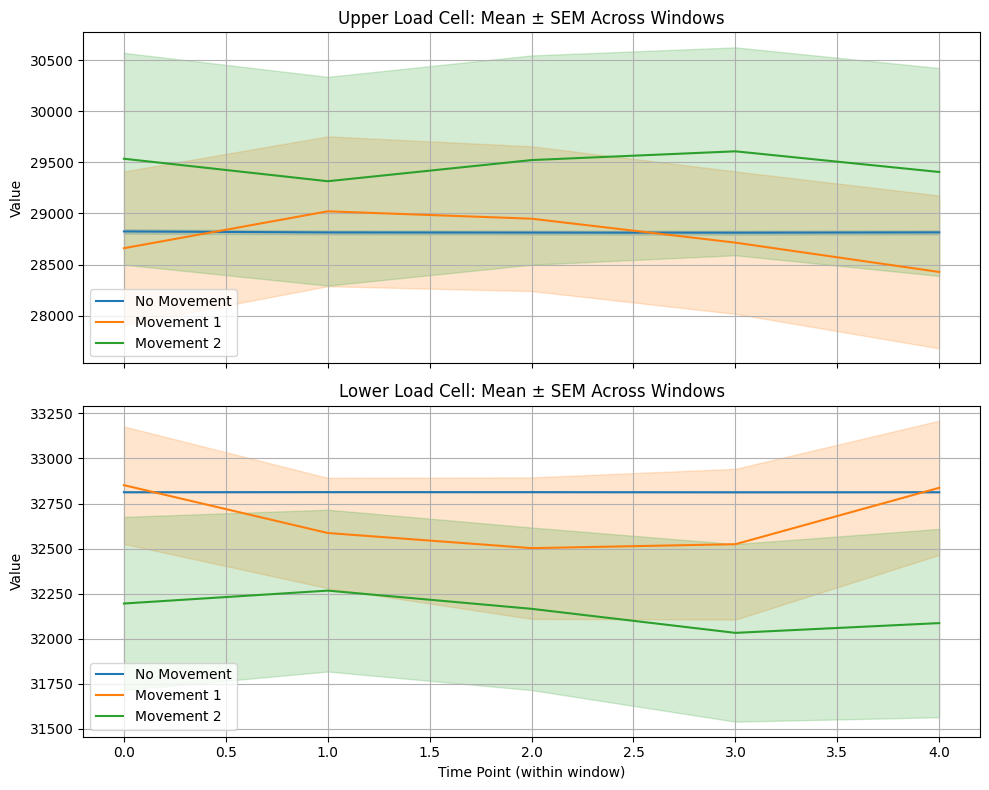

In [12]:
plot_mean_sem_across_windows(df_no, df_1, df_2, col, col2, window_size=5)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy.signal import welch

def plot_mean_sem_and_psd_across_windows(df_no, df_1, df_2, col, col2, window_size=5, fs=1.0):
    """
    Plot mean ± SEM for upper and lower load cell signals across all windows,
    and plot the PSD of the mean signal for each movement type.
    """
    dfs = {'No Movement': df_no, 'Movement 1': df_1, 'Movement 2': df_2}
    colors = {'No Movement': 'tab:blue', 'Movement 1': 'tab:orange', 'Movement 2': 'tab:green'}
    n_windows = min(len(df_no) // window_size, len(df_1) // window_size, len(df_2) // window_size)
    time_points = np.arange(window_size)

    # Prepare containers for all windowed segments
    data = {label: {'upper': [], 'lower': []} for label in dfs}
    for label, df in dfs.items():
        for i in range(n_windows):
            start = i * window_size
            end = start + window_size
            data[label]['upper'].append(df[col].iloc[start:end].values)
            data[label]['lower'].append(df[col2].iloc[start:end].values)
        data[label]['upper'] = np.stack(data[label]['upper'])
        data[label]['lower'] = np.stack(data[label]['lower'])

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    # --- Time domain plots ---
    for idx, load_cell in enumerate(['upper', 'lower']):
        for label in dfs:
            mean_vals = np.mean(data[label][load_cell], axis=0)
            sem_vals = sem(data[label][load_cell], axis=0)
            axs[idx, 0].plot(time_points, mean_vals, label=label, color=colors[label])
            axs[idx, 0].fill_between(time_points, mean_vals - sem_vals, mean_vals + sem_vals,
                                    color=colors[label], alpha=0.2)
        axs[idx, 0].set_title(f"{load_cell.capitalize()} Load Cell: Mean ± SEM Across Windows")
        axs[idx, 0].set_xlabel('Time Point (within window)')
        axs[idx, 0].set_ylabel('Value')
        axs[idx, 0].legend()
        axs[idx, 0].grid(True)

    # --- PSD plots of the mean signal ---
    for idx, load_cell in enumerate(['upper', 'lower']):
        for label in dfs:
            mean_vals = np.mean(data[label][load_cell], axis=0)
            f, Pxx = welch(mean_vals, fs=fs, nperseg=window_size)
            axs[idx, 1].semilogy(f, Pxx, label=label, color=colors[label])
        axs[idx, 1].set_title(f"{load_cell.capitalize()} Load Cell: PSD of Mean Signal")
        axs[idx, 1].set_xlabel('Frequency [Hz]')
        axs[idx, 1].set_ylabel('PSD')
        axs[idx, 1].legend()
        axs[idx, 1].grid(True)

    plt.tight_layout()
    plt.show()

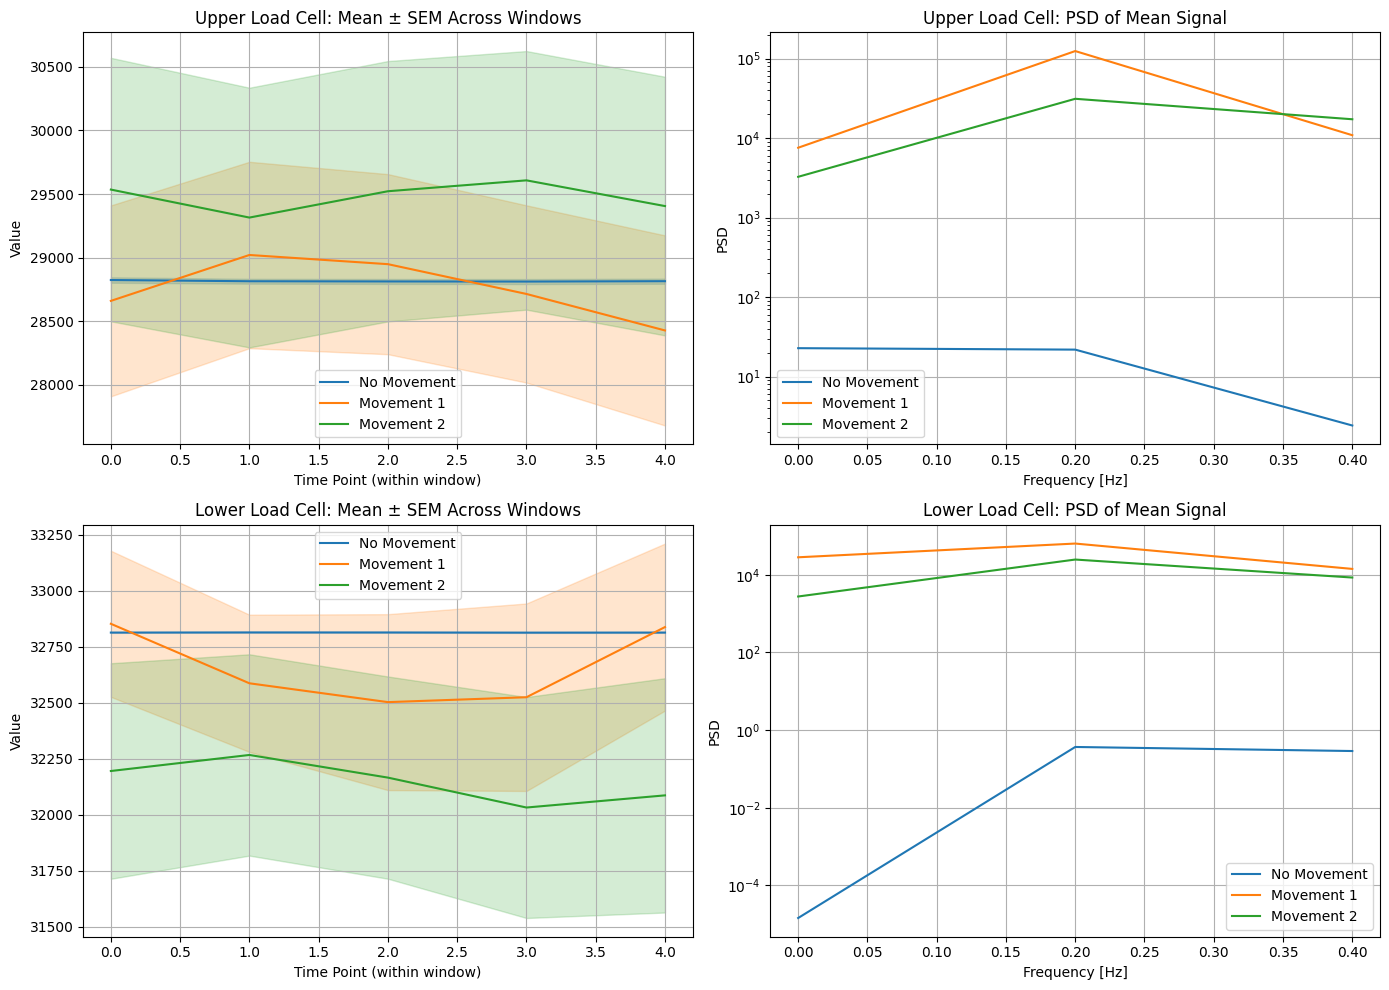

In [10]:
plot_mean_sem_and_psd_across_windows(df_no, df_1, df_2, col, col2, window_size=5, fs=1.0)

In [14]:
import numpy as np
from scipy.stats import sem
from scipy.signal import welch

def quantify_sem_and_psd_error(df_no, df_1, df_2, col, col2, window_size=5, fs=1.0):
    """
    Quantifies SEM and PSD-based error metrics for upper and lower load cell signals
    across all windows and for each movement type.
    Returns a nested dictionary with all results.
    """
    dfs = {'No Movement': df_no, 'Movement 1': df_1, 'Movement 2': df_2}
    results = {}
    n_windows = min(len(df_no) // window_size, len(df_1) // window_size, len(df_2) // window_size)
    for label, df in dfs.items():
        upper_segments = []
        lower_segments = []
        for i in range(n_windows):
            start = i * window_size
            end = start + window_size
            upper_segments.append(df[col].iloc[start:end].values)
            lower_segments.append(df[col2].iloc[start:end].values)
        upper_segments = np.stack(upper_segments)
        lower_segments = np.stack(lower_segments)
        mean_upper = np.mean(upper_segments, axis=0)
        mean_lower = np.mean(lower_segments, axis=0)
        sem_upper = sem(upper_segments, axis=0)
        sem_lower = sem(lower_segments, axis=0)
        rel_sem_upper = sem_upper / np.abs(mean_upper)
        rel_sem_lower = sem_lower / np.abs(mean_lower)
        # PSD of the mean signal
        f_upper, Pxx_upper = welch(mean_upper, fs=fs, nperseg=window_size)
        f_lower, Pxx_lower = welch(mean_lower, fs=fs, nperseg=window_size)
        results[label] = {
            'upper': {
                'mean_sem': float(np.mean(sem_upper)),
                'max_sem': float(np.max(sem_upper)),
                'mean_rel_sem_percent': float(np.mean(rel_sem_upper) * 100),
                'max_rel_sem_percent': float(np.max(rel_sem_upper) * 100),
                'total_psd_power': float(np.sum(Pxx_upper)),
                'max_psd': float(np.max(Pxx_upper))
            },
            'lower': {
                'mean_sem': float(np.mean(sem_lower)),
                'max_sem': float(np.max(sem_lower)),
                'mean_rel_sem_percent': float(np.mean(rel_sem_lower) * 100),
                'max_rel_sem_percent': float(np.max(rel_sem_lower) * 100),
                'total_psd_power': float(np.sum(Pxx_lower)),
                'max_psd': float(np.max(Pxx_lower))
            }
        }
    return results

# Example usage:
error_stats = quantify_sem_and_psd_error(df_no, df_1, df_2, col, col2, window_size=5, fs=1.0)
import pprint; pprint.pprint(error_stats)

{'Movement 1': {'lower': {'max_psd': 64022.31760680563,
                          'max_rel_sem_percent': 1.2856887137805477,
                          'max_sem': 418.1620476334182,
                          'mean_rel_sem_percent': 1.1116510810467894,
                          'mean_sem': 362.9812335994004,
                          'total_psd_power': 106608.79115473368},
                'upper': {'max_psd': 124091.84082485968,
                          'max_rel_sem_percent': 2.629041619656785,
                          'max_sem': 750.5273938672885,
                          'mean_rel_sem_percent': 2.528909492159314,
                          'mean_sem': 727.0601981908503,
                          'total_psd_power': 142481.43161339834}},
 'Movement 2': {'lower': {'max_psd': 24798.23572085689,
                          'max_rel_sem_percent': 1.6286411038237802,
                          'max_sem': 522.5758336350282,
                          'mean_rel_sem_percent': 1.490747830777108,
  